<a id='0'></a>
# **PyPSA-PH: A High Spatial and Temporal Resolution Open Source Model for the Philippine Power Grid**
Arizeo C. Salac *(arizeo.salac@phd.unipi.it)* | DESTEC, University of Pisa, Largo Lucio Lazzarino, 56122 Pisa, Italy

## **Introduction**

The Philippine power system is undergoing rapid transformation, driven by the need for increased renewable energy (RE) integration, grid modernization, and the pursuit of sustainable, reliable, and affordable electricity. To support these goals, advanced modeling tools are essential for analyzing the current state of the grid, evaluating future scenarios, and informing policy and investment decisions.

This notebook presents the development of a high-resolution baseline model for the Philippine power system using [PyPSA (Python for Power System Analysis)](https://pypsa.readthedocs.io/en/latest/), an open-source framework for simulating and optimizing modern energy systems. The model, referred to as PyPSA-PH, is designed to capture the unique characteristics of the Philippine grid, including its actual trading node spatial resolution and sub-daily (hourly or finer) temporal resolution. This enables detailed analysis of RE intermittency, grid bottlenecks, and operational challenges.

The workflow implemented in this notebook encompasses the following key steps:
- **Data Import and Preprocessing:** Loading and preparing network topology, generator, storage, and time series data from actual Philippine system records and relevant administrative datasets.
- **Network Construction:** Building the PyPSA network by adding buses, loads, generators, storage units, and transmission lines, with options for spatial aggregation and detailed mapping of assets.
- **Cost and Technology Mapping:** Integrating technology-specific cost data, efficiency parameters, and lifetime assumptions to ensure realistic economic modeling.
- **Temporal Resolution and Snapshots:** Setting up the model to operate at a chosen temporal granularity, allowing for the study of daily and seasonal variability in demand and renewable generation.
- **Optimization and Scenario Analysis:** Solving the baseline model using linear optimization to determine the optimal dispatch of resources, and extending the analysis to future scenarios with varying technology mixes, demand projections, and policy constraints (e.g., CO₂ reduction targets).
- **Results Visualization and Verification:** Generating plots and statistics to interpret model outputs, including network topology, dispatch profiles, generation mix, and key performance indicators such as LCOE and emissions.
- **Scenario Functions:** Providing reusable functions for projecting the network into future years, incorporating new technologies, and evaluating the impact of different policy and investment strategies.

## **Research Objectives**

*Main Objective:*  
Develop a higher-resolution baseline PyPSA model for the Philippines (PyPSA-PH) with:  
1. Actual trading node spatial resolution; and  
2. Hourly (or sub-daily) time resolution to capture RE intermittency.

*Specifically, this study aims to:*
1. Verify the model with actual generation output from the Wholesale Electricity Spot Market (WESM);
2. Compare actual WESM trading prices with model-calculated prices per trading node;
3. Identify current line loadings and potential capacity expansion needs, benchmarking against the Transmission Development Plan.

By following this workflow, the notebook provides a robust foundation for power system analysis in the Philippines, supporting both academic research and practical planning for a sustainable energy future.

**Important links/references:**  
[TU Berlin: Data Science for Energy System Modelling](https://fneum.github.io/data-science-for-esm/intro.html#jupyter.org/)  
[PyPSA Documentation and Components](https://pypsa.readthedocs.io/en/latest/user-guide/components.html)  
[PyPSA Earth Documentation](https://pypsa-earth.readthedocs.io/en/latest/)  
[GitHub PyPSA Sources](https://github.com/PyPSA)  

## Table of Contents
[01 Import Packages](#01-Import-packages)  

[02 Create Network](#02-Create-Network)  
  [02.01 Load Network Data](#02-Create-Network)  
  [02.02 Initialize the network](#02-Create-Network)  

[03 Add Network Components](#03-Add-Network-Components)  
  [03.01 Setting Time Snapshots and Temporal Resolution](#03-Add-Network-Components)  
  [03.02 Adding Loads and Load Time Series](#03-Add-Network-Components)  
  [03.03 Adding Generators and Generator Time Series](#03-Add-Network-Components)  
  [03.04 Setting up Buses and Spatial Resolution](#03-Add-Network-Components)  
  [03.05 Adding Storage Units](#03-Add-Network-Components)  
  [03.06 Adding Lines](#03-Add-Network-Components)  
  [03.07 Adding Carriers](#03-Add-Network-Components)  

[04 Optimizing the Network Baseline Model](#04-Optimizing-the-Network-Baseline-Model)  

[05 Baseline Model Results](#05-Baseline-Model-Results)  
  [05.01 Storing Baseline Model](#05-Baseline-Model-Results)  
  [05.02 Verification of Results](#05-Baseline-Model-Results)  

[06 Future Case Scenario Simulations](#06-Future-Case-Scenario-Simulations)  
  [06.01 Code Functions for Projection to Future Scenarios](#06-Future-Case-Scenario-Simulations)  
  [06.02 Definition of Functions for Future Simulations](#06-Future-Case-Scenario-Simulations)  
  [06.03 Visualize Future Scenario Results](#06-Future-Case-Scenario-Simulations)  


<a id="01-Import-packages"></a>
### 01 Import 

This section imports all necessary Python packages and libraries required for data processing, power system modeling, geospatial analysis, and visualization. These packages provide the foundational tools for building, analyzing, and visualizing the PyPSA-PH baseline model.

In [1]:
import pypsa
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from pypsa.plot import add_legend_patches
import os
import glob

<a id="02-Create-Network"></a>
### 02 Create Network

This section covers the creation of the PyPSA-PH network, including loading network data, initializing the PyPSA network object, and preparing the structure for adding buses, loads, generators, storage units, and transmission lines. The steps here lay the foundation for building a detailed and high-resolution model of the Philippine power system.

#### 02.01 Load Network Data

In [2]:
buses_df = pd.read_csv('data/buses.csv')
storageunits_df = pd.read_csv('data/storageunits.csv')
generators_df = pd.read_csv('data/generators.csv')
lines_df = pd.read_csv('data/lines.csv')
loads_time_series_df = pd.read_csv('data/loads_t.csv', index_col=0, parse_dates=True, date_format='%m/%d/%y %H:%M')
generators_time_series_df = pd.read_csv('data/generators_t.csv', index_col=0, parse_dates=True, date_format='%m/%d/%y %H:%M')
area_df = pd.read_csv('data/admin_regions.csv')
future_loads = pd.read_csv('data/area_data_future.csv').set_index('Area')
district_RE = pd.read_csv('data/district_RE.csv',index_col=0, parse_dates=True, date_format='%m/%d/%y %H:%M')

In [3]:
# Load costs data
def calc_annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

def get_costs_data(year):
    path = f"data/Cost_Data_2020-2050/costs_{year}.csv"
    costs_data = pd.read_csv(path, delimiter=",")
    costs_data.loc[costs_data.unit.str.contains("/kW"), "value"] *= 1e3
    costs_data.unit = costs_data.unit.str.replace("/kW", "/MW")
    costs_data.set_index(['technology', 'parameter'], inplace=True)
    defaults = {
        "FOM": 0, "VOM": 0, "efficiency": 1, "fuel": 0, "investment": 0,
        "lifetime": 25, "CO2 intensity": 0, "discount rate": 0.07,
    }
    costs_data = costs_data.value.unstack().fillna(defaults)

    #Pre-assignment of lost data:
    costs_data.at["geothermal", "investment"] = 262580.50 # 0.29M-USD/MW assumed for all year https://www.geothermal-energy.org/pdf/IGAstandard/INAGA/2001/2001-27.pdf

    # Calculations
    annuity = costs_data.apply(lambda x: calc_annuity(x["discount rate"], x["lifetime"]), axis=1)
    costs_data["capital_cost"] = (annuity + costs_data["FOM"] / 100) * costs_data["investment"]
    costs_data["marginal_cost"] = costs_data["VOM"] + costs_data["fuel"] / costs_data["efficiency"]

    # Specific assignments
    costs_data.at["solid biomass boiler steam", "fuel"] = costs_data.at["solid biomass", "fuel"]
    costs_data.at["solid biomass boiler steam", "CO2 intensity"] = costs_data.at["solid biomass", "CO2 intensity"]
    costs_data.at["gas boiler steam", "fuel"] = costs_data.at["gas", "fuel"]
    costs_data.at["gas boiler steam", "CO2 intensity"] = costs_data.at["gas", "CO2 intensity"]
    costs_data.at["battery storage", "marginal_cost"] = costs_data.at["battery storage", "marginal_cost"] + costs_data.at["battery inverter", "marginal_cost"]*4
    costs_data.at["battery storage", "capital_cost"] = costs_data.at["battery storage", "capital_cost"] + costs_data.at["battery inverter", "capital_cost"]*4
    costs_data.at["battery storage", "efficiency"] = costs_data.at["battery inverter", "efficiency"]
    costs_data.at["Pumped-Storage-Hydro-store", "marginal_cost"] = costs_data.at["Pumped-Storage-Hydro-store", "marginal_cost"] + costs_data.at["Pumped-Storage-Hydro-bicharger", "marginal_cost"]*6
    costs_data.at["Pumped-Storage-Hydro-store", "capital_cost"] = costs_data.at["Pumped-Storage-Hydro-store", "capital_cost"] + costs_data.at["Pumped-Storage-Hydro-bicharger", "capital_cost"]*6
    costs_data.at["Pumped-Storage-Hydro-store", "efficiency"] = costs_data.at["Pumped-Storage-Hydro-bicharger", "efficiency"]

    return costs_data

year = 2020
costs_data = get_costs_data(year)

In [4]:
tech_map = {
    "Gas": "gas boiler steam", "Solar": "solar", "Wind": "onwind",
    "Diesel": "oil", "Coal": "coal", "Hydro": "hydro", "Geothermal": "geothermal",
    "Biomass": "solid biomass boiler steam", "ROR":"ror", "Battery": "battery storage", 
    "Pump Hydro":"Pumped-Storage-Hydro-store"}

reverse_tech_map = {v: k for k, v in tech_map.items()}

#### 02.02 Initialize the network

In [5]:
n = pypsa.Network()

### 03 Add Network Components

This section details the process of adding key components to the PyPSA-PH network, including buses, loads, generators, storage units, and transmission lines. Each component is integrated with relevant time series data and technical parameters to accurately represent the Philippine power system's structure and operation.

#### 03.01 Setting Time Snapshots and Temporal Resolution

This step sets the temporal resolution for the simulation by resampling the load and generator time series data to a specified frequency (e.g., every 3 hours = '3h'). It then defines the model's snapshots, which represent the time intervals over which the network will be simulated, ensuring consistency between the time series data and the network's operational timeline.

In [6]:
# Setting temporal resolution, this can be adjusted as needed
freq = '3h'

# Resample the time series data to daily resolution (or modify as needed)
loads_time_series_df = loads_time_series_df.resample(freq).mean()
generators_time_series_df = generators_time_series_df.resample(freq).mean()

# Adjust snapshots for daily resolution
snapshots = pd.date_range(start="2023-01-01 00:00:00", end="2023-12-31 23:00:00", freq=freq)
n.set_snapshots(snapshots)

#### 03.02 Adding Loads and Load Time Series

This step integrates the processed load time series data into the PyPSA network. Each bus is assigned a corresponding load, and the time-varying demand profiles are set using the resampled `loads_time_series_df`. This ensures that the network accurately represents the spatial and temporal distribution of electricity demand across all nodes for the simulation period.

The network allows for flexible spatial aggregation of loads and buses to match different administrative or planning boundaries. By setting the `AGGREGATE_BUSES` variable, users can control whether and how the buses are aggregated:

- Set to `False` to use the original, unaggregated bus structure (each bus represents a physical node).
- Set to a specific code to aggregate buses and loads according to a chosen scheme:
    - `'adm1_en'`: Aggregate by Administrative Regions.
    - `'adm2_en'`: Aggregate by Administrative Provinces.
    - `'custom_TDP1'`: Aggregate by NGCP Regional Transmission Groups.
    - `'custom_TDP2'`: Aggregate by NGCP Transmission Districts.

This approach enables the model to be adapted for analyses at different spatial resolutions, from detailed nodal studies to higher-level regional planning.

In [7]:
AGGREGATE_BUSES = 'custom_TDP2'

In [8]:
if AGGREGATE_BUSES:
    shapefile = 'data/PH_Adm2_ProvDists'
    philippines_shapes = gpd.read_file(shapefile).to_crs(epsg=4326)
    philippines_shapes.adm2_en = area_df[AGGREGATE_BUSES]
    combined_gdf = philippines_shapes.dissolve(by='adm2_en') 

    buses_gdf = gpd.GeoDataFrame(buses_df, geometry=gpd.points_from_xy(buses_df.x, buses_df.y), crs=combined_gdf.crs)
    buses_gdf = buses_gdf.to_crs(combined_gdf.crs)

    buses_gdf = buses_gdf.drop(columns=['index_left', 'index_right'], errors='ignore')
    combined_gdf = combined_gdf.drop(columns=['index_left', 'index_right'], errors='ignore')

    buses_gdf = gpd.sjoin(buses_gdf, combined_gdf, how="left", predicate="within")
    buses_gdf = buses_gdf.rename(columns={buses_gdf.columns[0]: 'name'})

    grouped_buses = buses_gdf.groupby("adm2_en")

    for name, group in grouped_buses:
        aggregated_bus = {
            'name': f'{name}',
            'x': group.geometry.x.mean(),
            'y': group.geometry.y.mean(),
            'v_nom': group['v_nom'].max()}
        n.add("Bus", **aggregated_bus)

    aggregated_loads_t = pd.DataFrame(index=loads_time_series_df.index)
    for name, group in grouped_buses:
        load_columns = group['name'].tolist()
        aggregated_loads_t[f'{name}'] = loads_time_series_df[load_columns].sum(axis=1)

    n.loads_t.p_set = aggregated_loads_t
    for load in n.loads_t.p_set.columns:
        n.add("Load", load, bus=load)

    bus_mapping = {old_bus: new_bus for new_bus, group in grouped_buses for old_bus in group['name']}

else:
    # No aggregation: directly add buses
    for _, row in buses_df.iterrows():
        n.add("Bus", name=row['name'], x=row['x'], y=row['y'], v_nom=row['v_nom'])

    # No aggregation: assign raw loads and buses
    n.loads_t.p_set = loads_time_series_df
    for load in n.loads_t.p_set.columns:
        n.add("Load", load, bus=load)

    # Mapping is identity
    bus_mapping = {bus: bus for bus in buses_df['name']}


/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pyogrio/geopandas.py:265: UserWarning:

More than one layer found in 'PH_Adm2_ProvDists': 'PH_Adm2_ProvDists.shp' (default), 'Provdists.shp'. Specify layer parameter to avoid this warning.



#### 03.03 Adding Generators and Generator Time Series

In [9]:
if AGGREGATE_BUSES:
    # Define mapping from original buses to aggregated ones
    bus_mapping = {old_bus: new_bus for new_bus, group in grouped_buses for old_bus in group['name']}
else:
    # No aggregation: map each bus to itself
    bus_mapping = {bus: bus for bus in generators_df['bus'].unique()}

# Update the generators with the new bus connections
for index, row in generators_df.iterrows():
    tech = tech_map.get(row['carrier'])
    n.add("Generator", name=row['name'], bus=bus_mapping.get(row['bus'], row['bus']), 
          p_nom=row['p_nom'], carrier=row['carrier'],
          efficiency=costs_data.at[tech, "efficiency"], 
          marginal_cost=costs_data.at[tech, "marginal_cost"],
          capital_cost=costs_data.at[tech, "capital_cost"],
          lifetime=row['build_year']+costs_data.at[tech, "lifetime"],
          p_nom_extendable=False)

# Assign all time series data for generators
n.generators_t.p_max_pu = generators_time_series_df

#### 03.04 Setting up Buses and Spatial Resolution

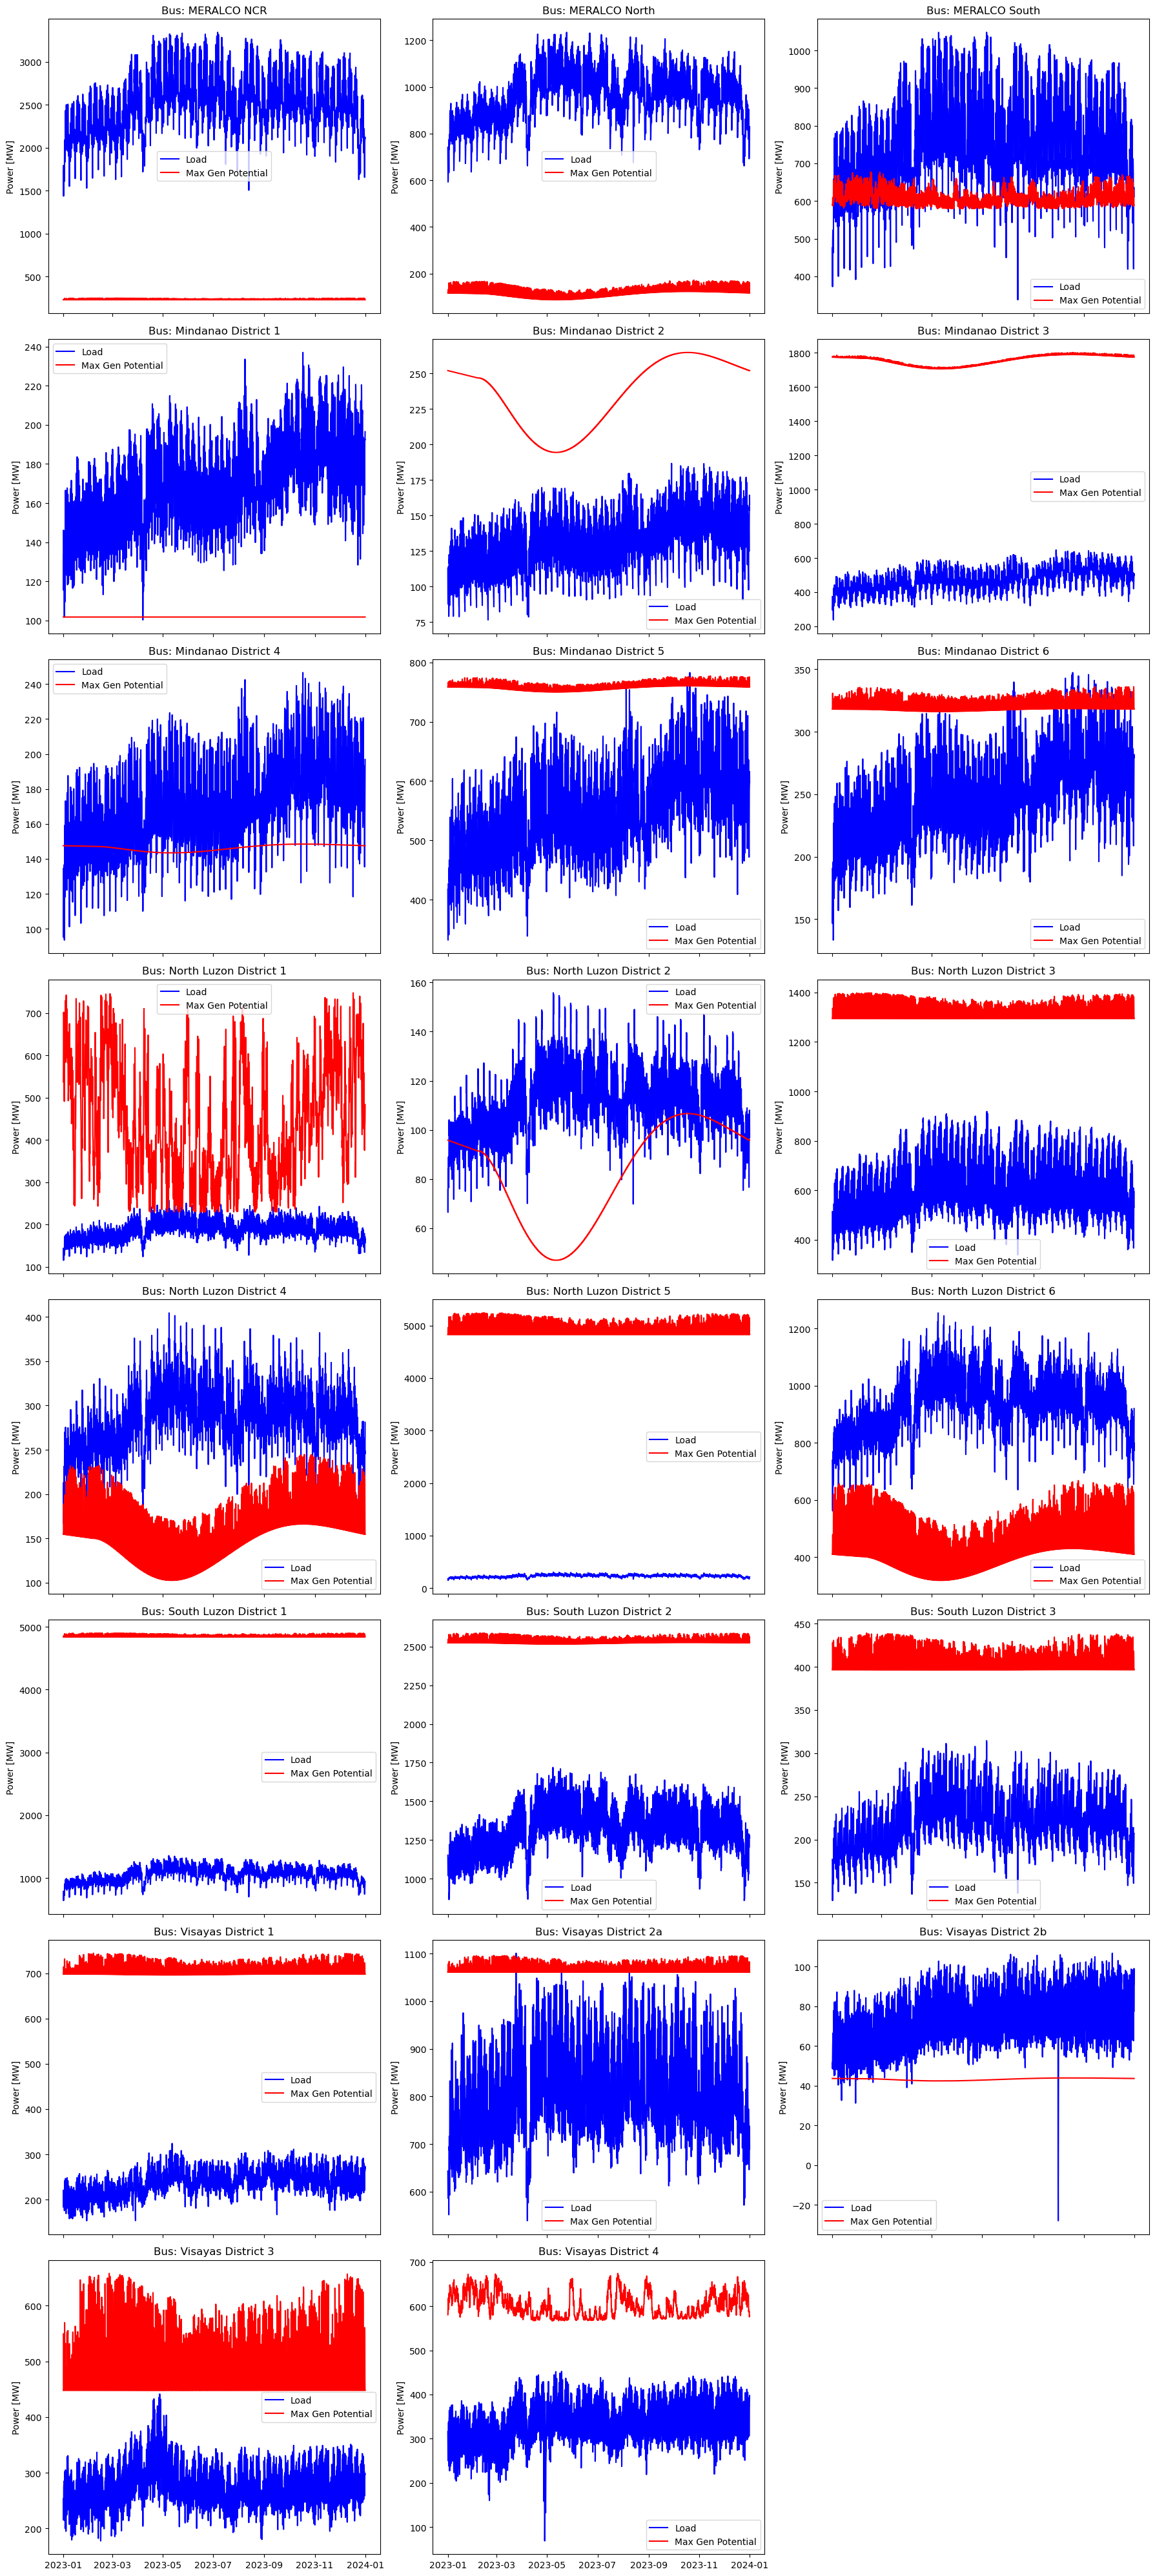

In [10]:
# Get all unique buses in the network
buses = n.buses.index

# Set up the plotting grid with 3 columns
n_rows = (len(buses) + 2) // 3  # Calculate the number of rows needed
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5 * n_rows), sharex=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop over each bus
for i, bus in enumerate(buses):
    ax = axes[i]
    
    # Plot the load curve
    if bus in n.loads.bus.values:
        load_at_bus = n.loads_t.p_set.loc[:, n.loads[n.loads.bus == bus].index].sum(axis=1)
        ax.plot(n.snapshots, load_at_bus, label='Load', color='blue')

    # Plot the time series of maximum generation potential
    if bus in n.generators.bus.values:
        gens_at_bus = n.generators[n.generators.bus == bus]
        max_gen_potential = (n.generators_t.p_max_pu.loc[:, gens_at_bus.index] * gens_at_bus.p_nom).sum(axis=1)
        ax.plot(n.snapshots, max_gen_potential, label='Max Gen Potential', color='red')

    # Title and labels
    ax.set_title(f'Bus: {bus}')
    ax.set_ylabel('Power [MW]')
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 03.05 Adding Storage Units

In [11]:
for index, row in storageunits_df.iterrows():
    tech = tech_map.get(row['carrier'])
    bus = bus_mapping.get(row['bus'], row['bus'])
    
    # Check if the bus exists in the network
    if bus not in n.buses.index:
        # Add the bus if it doesn't exist
        n.add("Bus", name=bus)
    
    # Add the storage unit
    n.add("StorageUnit", row['name'], bus=bus, 
          p_nom=row['p_nom'], carrier=row['carrier'],
          max_hours=4, efficiency_dispatch=costs_data.at[tech, "efficiency"],
          efficiency_store=costs_data.at[tech, "efficiency"],
          capital_cost=costs_data.at[tech, "capital_cost"],
          marginal_cost=costs_data.at[tech, "marginal_cost"],
          lifetime=row['build_year']+costs_data.at[tech, "lifetime"],
          p_nom_extendable=False)

#### 03.06 Adding Lines

In [12]:
# Correct the code for adding lines to use the `bus_mapping`
def get_standard_current(voltage):
    if 60 <= voltage < 100:
        return 550  # for voltages roughly in the 69 kV range
    elif 100 <= voltage < 200:
        return 900  # for voltages roughly in the 138 kV range
    elif 200 <= voltage < 400:
        return 1100 # for voltages roughly in the 230 kV range
    elif 400 <= voltage <= 500:
        return 1750 # for voltages roughly in the 500 kV range
    else:
        return 1000 # default or estimate for other voltages

def calculate_s_nom_from_voltage(voltage):
    I = get_standard_current(voltage)
    S_nom = 1.732 * voltage * I / 1000 # S_nom in MVA if voltage in kV, I in A
    return S_nom

for index, row in lines_df.iterrows():
    bus0 = bus_mapping.get(row['bus0'], row['bus0'])
    bus1 = bus_mapping.get(row['bus1'], row['bus1'])
    if not (bus0 == bus1):
        for i in range(int(row['cables']), 0, -1):
            n.add("Line", f"{row['name']}_{i}", bus0=bus0, bus1=bus1,
                  x=row['x'], r=row['r'], 
                  s_nom= calculate_s_nom_from_voltage(row['s_nom']), 
                  s_nom_extendable=True)

#### 03.07 Adding Carriers

In [13]:
carrier_list = n.generators.carrier.unique()
for carrier in carrier_list:
        n.add("Carrier", carrier, co2_emissions=costs_data.at[tech_map.get(carrier), 'CO2 intensity'])
n.add("Carrier", "AC", co2_emissions=0)
n.add("Carrier", "Battery", co2_emissions=0)
n.add("Carrier", "Pump Hydro", co2_emissions=0)

In [14]:
carrier_colors = {
    "Biomass": '#127E2A',
    "Hydro": '#1E81D4',
    "Coal": '#342C27',
    "Solar": '#FDB324',
    "Wind": '#3BBFE5',
    "Diesel": '#B41E25',
    "Gas": '#564A41',
    "Geothermal": '#E6622D',
    "ROR": '#8ab2d4',
    "Battery": '#814ad4',
    "Pump Hydro": '#104775'}

for carrier, color in carrier_colors.items():
    n.carriers.loc[carrier, 'color'] = color

### 04 Optimizing the Network Baseline Model

This section focuses on optimizing the baseline PyPSA-PH network model. Here, the model is solved using a linear optimization solver to determine the optimal dispatch of generators, storage, and transmission assets, subject to technical and economic constraints. The results provide insights into system operation, bottlenecks, and the cost-effectiveness of the current network configuration. Subsequent cells also include exporting results, analyzing infeasibilities, and visualizing key outputs to verify and interpret the optimization outcomes.

In [15]:
# Optimize the network, select solver as needed
n.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-13


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-05-13
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]
INFO:linopy.io: Writing time: 10.79s


Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-yghvlr_k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-yghvlr_k.lp


Reading time = 4.33 seconds


INFO:gurobipy:Reading time = 4.33 seconds


obj: 3886624 rows, 1755024 columns, 6900040 nonzeros


INFO:gurobipy:obj: 3886624 rows, 1755024 columns, 6900040 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Apple M1


INFO:gurobipy:CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 3886624 rows, 1755024 columns and 6900040 nonzeros


INFO:gurobipy:Optimize a model with 3886624 rows, 1755024 columns and 6900040 nonzeros


Model fingerprint: 0x63373117


INFO:gurobipy:Model fingerprint: 0x63373117


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [4e-01, 2e+02]


INFO:gurobipy:  Matrix range     [4e-01, 2e+02]


  Objective range  [1e-02, 2e+02]


INFO:gurobipy:  Objective range  [1e-02, 2e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e-04, 3e+03]


INFO:gurobipy:  RHS range        [2e-04, 3e+03]


Presolve removed 3799024 rows and 1439373 columns


INFO:gurobipy:Presolve removed 3799024 rows and 1439373 columns


Presolve time: 2.30s


INFO:gurobipy:Presolve time: 2.30s


Presolved: 87600 rows, 315651 columns, 611927 nonzeros


INFO:gurobipy:Presolved: 87600 rows, 315651 columns, 611927 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Free vars  : 14600


INFO:gurobipy: Free vars  : 14600


 AA' NZ     : 1.255e+05


INFO:gurobipy: AA' NZ     : 1.255e+05


 Factor NZ  : 9.196e+05 (roughly 120 MB of memory)


INFO:gurobipy: Factor NZ  : 9.196e+05 (roughly 120 MB of memory)


 Factor Ops : 1.655e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.655e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.60987874e+10 -1.06425135e+11  2.62e+04 1.19e+02  4.08e+06     3s


INFO:gurobipy:   0   1.60987874e+10 -1.06425135e+11  2.62e+04 1.19e+02  4.08e+06     3s


   1   2.75072046e+09 -6.04983823e+10  2.40e+03 1.87e-02  4.65e+05     3s


INFO:gurobipy:   1   2.75072046e+09 -6.04983823e+10  2.40e+03 1.87e-02  4.65e+05     3s


   2   1.34640193e+09 -1.98998012e+10  9.01e+01 3.41e-03  5.82e+04     3s


INFO:gurobipy:   2   1.34640193e+09 -1.98998012e+10  9.01e+01 3.41e-03  5.82e+04     3s


   3   8.74937324e+08 -4.89521115e+09  2.32e+00 9.74e-04  1.36e+04     3s


INFO:gurobipy:   3   8.74937324e+08 -4.89521115e+09  2.32e+00 9.74e-04  1.36e+04     3s


   4   7.08542704e+08 -4.35718567e+08  2.08e-01 1.03e-03  2.68e+03     3s


INFO:gurobipy:   4   7.08542704e+08 -4.35718567e+08  2.08e-01 1.03e-03  2.68e+03     3s


   5   5.96733675e+08  3.32378190e+08  2.86e-02 5.40e-04  6.19e+02     3s


INFO:gurobipy:   5   5.96733675e+08  3.32378190e+08  2.86e-02 5.40e-04  6.19e+02     3s


   6   5.58881697e+08  4.93908534e+08  7.17e-03 3.22e-04  1.52e+02     3s


INFO:gurobipy:   6   5.58881697e+08  4.93908534e+08  7.17e-03 3.22e-04  1.52e+02     3s


   7   5.43693616e+08  5.28906430e+08  1.85e-03 2.11e-04  3.46e+01     3s


INFO:gurobipy:   7   5.43693616e+08  5.28906430e+08  1.85e-03 2.11e-04  3.46e+01     3s


   8   5.37498406e+08  5.36004506e+08  9.60e-05 1.35e-04  3.50e+00     3s


INFO:gurobipy:   8   5.37498406e+08  5.36004506e+08  9.60e-05 1.35e-04  3.50e+00     3s


   9   5.36892059e+08  5.36795884e+08  3.29e-06 5.11e-05  2.25e-01     3s


INFO:gurobipy:   9   5.36892059e+08  5.36795884e+08  3.29e-06 5.11e-05  2.25e-01     3s


  10   5.36855435e+08  5.36845207e+08  2.08e-07 1.07e-05  2.40e-02     3s


INFO:gurobipy:  10   5.36855435e+08  5.36845207e+08  2.08e-07 1.07e-05  2.40e-02     3s


  11   5.36850872e+08  5.36849210e+08  1.09e-08 2.82e-06  3.89e-03     3s


INFO:gurobipy:  11   5.36850872e+08  5.36849210e+08  1.09e-08 2.82e-06  3.89e-03     3s


  12   5.36850522e+08  5.36850515e+08  4.09e-12 9.81e-08  1.62e-05     3s


INFO:gurobipy:  12   5.36850522e+08  5.36850515e+08  4.09e-12 9.81e-08  1.62e-05     3s


  13   5.36850519e+08  5.36850519e+08  3.64e-12 1.56e-11  6.03e-11     3s


INFO:gurobipy:  13   5.36850519e+08  5.36850519e+08  3.64e-12 1.56e-11  6.03e-11     3s


INFO:gurobipy:


Barrier solved model in 13 iterations and 3.23 seconds (4.45 work units)


INFO:gurobipy:Barrier solved model in 13 iterations and 3.23 seconds (4.45 work units)


Optimal objective 5.36850519e+08


INFO:gurobipy:Optimal objective 5.36850519e+08


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   40880 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:   40880 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:


   11680 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:   11680 PPushes remaining with PInf 0.0000000e+00                 3s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.1382709e-11      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.1382709e-11      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   52563    5.3685052e+08   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   52563    5.3685052e+08   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:


   10231 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:   10231 PPushes remaining with PInf 0.0000000e+00                 3s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3847008e-10      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3847008e-10      3s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   65724    5.3685052e+08   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:   65724    5.3685052e+08   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:


Solved in 65724 iterations and 4.89 seconds (6.16 work units)


INFO:gurobipy:Solved in 65724 iterations and 4.89 seconds (6.16 work units)


Optimal objective  5.368505189e+08


INFO:gurobipy:Optimal objective  5.368505189e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1755024 primals, 3886624 duals
Objective: 5.37e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-ext-s-lower, Line-ext-s-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

### 05 Baseline Model Results

This section presents the results of the baseline PyPSA-PH model simulation. It includes key performance indicators such as network statistics, exported model files, visualizations of network topology, generation dispatch, generation mix, and verification of results. These outputs provide insights into the operational characteristics, bottlenecks, and overall performance of the current power system configuration in the Philippines.

#### 05.01 Storing Baseline Model

In [16]:
n.statistics()

Optimal Capacity  Installed Capacity        Supply  \
Generator   Biomass           466.100000            466.1000  1.361012e+06   
            Coal            12374.100000          12374.1000  1.614035e+07   
            Diesel           2811.400000           2811.4000  0.000000e+00   
            Gas              3732.300000           3732.3000  1.089832e+07   
            Geothermal       1754.900000           1754.9000  5.124308e+06   
            Hydro            1966.500000           1966.5000  1.200241e+06   
            ROR              1067.500000           1067.5000  6.515420e+05   
            Solar            2271.300000           2271.3000  1.065691e+06   
            Wind              569.500000            569.5000  6.452306e+05   
Line        AC              37494.939697          47095.8512  6.256084e+07   
Load        -                   0.000000              0.0000  3.720684e+01   
StorageUnit Battery           597.000000            597.0000  0.000000e+00   
            Pump Hydro        735.600000            735.6000  0.000000e+00   

                          Withdrawal      Dispatch  Transmission  \
Generator   Biomass     0.000000e+00  1.361012e+06  0.000000e+00   
            Coal        0.000000e+00  1.614035e+07  0.000000e+00   
            Diesel      0.000000e+00  0.000000e+00  0.000000e+00   
            Gas         0.000000e+00  1.089832e+07  0.000000e+00   
            Geothermal  0.000000e+00  5.124308e+06  0.000000e+00   
            Hydro       0.000000e+00  1.200241e+06  0.000000e+00   
            ROR         0.000000e+00  6.515420e+05  0.000000e+00   
            Solar       0.000000e+00  1.065691e+06  0.000000e+00   
            Wind        0.000000e+00  6.452306e+05  0.000000e+00   
Line        AC          6.256084e+07  0.000000e+00  5.074176e+06   
Load        -           3.708673e+07 -3.708669e+07  0.000000e+00   
StorageUnit Battery     0.000000e+00  0.000000e+00  0.000000e+00   
            Pump Hydro  0.000000e+00  0.000000e+00  0.000000e+00   

                        Capacity Factor   Curtailment  Capital Expenditure  \
Generator   Biomass            1.000000  0.000000e+00         4.071566e+07   
            Coal               0.446700  1.999202e+07         4.172646e+09   
            Diesel             0.000000  8.197608e+06         1.137464e+08   
            Gas                1.000000  0.000000e+00         2.510852e+07   
            Geothermal         1.000000  0.000000e+00         4.635047e+07   
            Hydro              0.209022  4.508516e-08         3.592771e+08   
            ROR                0.209022  1.284238e-08         3.289719e+08   
            Solar              0.160685  1.887141e-07         1.710830e+08   
            Wind               0.388006  1.004982e-07         6.468620e+07   
Line        AC                 0.571409  0.000000e+00         0.000000e+00   
Load        -                       NaN  0.000000e+00         0.000000e+00   
StorageUnit Battery            0.000000  0.000000e+00         1.123436e+08   
            Pump Hydro         0.000000  0.000000e+00         5.037580e+08   

                        Operational Expenditure       Revenue  Market Value  
Generator   Biomass                3.808792e+06  4.384272e+07  3.221332e+01  
            Coal                   5.199342e+08  5.199342e+08  3.221332e+01  
            Diesel                 0.000000e+00  0.000000e+00  0.000000e+00  
            Gas                    1.207206e+07  3.510710e+08  3.221332e+01  
            Geothermal             0.000000e+00  1.650710e+08  3.221332e+01  
            Hydro                  0.000000e+00  3.866375e+07  3.221332e+01  
            ROR                    0.000000e+00  2.098833e+07  3.221332e+01  
            Solar                  1.129633e+04  3.432946e+07  3.221332e+01  
            Wind                   1.024175e+06  2.078502e+07  3.221332e+01  
Line        AC                     0.000000e+00  0.000000e+00           NaN  
Load        -              

In [17]:
n.export_to_netcdf("results/PyPSA-PH.nc")

INFO:pypsa.io:Exported network PyPSA-PH.nc has buses, lines, carriers, loads, storage_units, generators


<xarray.Dataset>
Dimensions:                            (snapshots: 2920, investment_periods: 0,
                                        buses_i: 23, buses_t_p_i: 23,
                                        buses_t_v_ang_i: 23,
                                        buses_t_marginal_price_i: 23,
                                        lines_i: 104, lines_t_p0_i: 104,
                                        lines_t_p1_i: 104, carriers_i: 12,
                                        loads_i: 23, loads_t_p_set_i: 23,
                                        loads_t_p_i: 23, storage_units_i: 24,
                                        storage_units_t_state_of_charge_i: 24,
                                        generators_i: 425,
                                        generators_t_p_max_pu_i: 165,
                                        generators_t_p_i: 305)
Coordinates: (12/18)
  * snapshots                          (snapshots) int64 0 1 2 ... 2918 2919
  * investment_periods                 (investment_periods) int64 
  * buses_i                            (buses_i) object 'MERALCO NCR' ... 'Vi...
  * buses_t_p_i                        (buses_t_p_i) object 'MERALCO NCR' ......
  * buses_t_v_ang_i                    (buses_t_v_ang_i) object 'MERALCO NCR'...
  * buses_t_marginal_price_i           (buses_t_marginal_price_i) object 'MER...
    ...                                 ...
  * loads_t_p_i                        (loads_t_p_i) object 'MERALCO NCR' ......
  * storage_units_i                    (storage_units_i) object '01CNCEP_BAT'...
  * storage_units_t_state_of_charge_i  (storage_units_t_state_of_charge_i) object ...
  * generators_i                       (generators_i) object '01ACNPC_G01' .....
  * generators_t_p_max_pu_i            (generators_t_p_max_pu_i) object '01AM...
  * generators_t_p_i                   (generators_t_p_i) object '01ACNPC_G01...
Data variables: (12/53)
    snapshots_snapshot                 (snapshots) datetime64[ns] 2023-01-01 ...
    snapshots_objective                (snapshots) float64 1.0 1.0 ... 1.0 1.0
    snapshots_stores                   (snapshots) float64 1.0 1.0 ... 1.0 1.0
    snapshots_generators               (snapshots) float64 1.0 1.0 ... 1.0 1.0
    investment_periods_objective       (investment_periods) object 
    investment_periods_years           (investment_periods) object 
    ...                                 ...
    generators_lifetime                (generators_i) float64 2.042e+03 ... 2...
    generators_capital_cost            (generators_i) float64 8.735e+04 ... 4...
    generators_efficiency              (generators_i) float64 0.89 0.9 ... 0.35
    generators_p_nom_opt               (generators_i) float64 3.2 37.5 ... 11.9
    generators_t_p_max_pu              (snapshots, generators_t_p_max_pu_i) float64 ...
    generators_t_p                     (snapshots, generators_t_p_i) float64 ...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           536850518.9214985
    network_objective_constant:  0.0
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

In [18]:
n.generators.carrier.unique()

array(['Biomass', 'Hydro', 'Coal', 'ROR', 'Solar', 'Wind', 'Diesel',
       'Gas', 'Geothermal'], dtype=object)

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



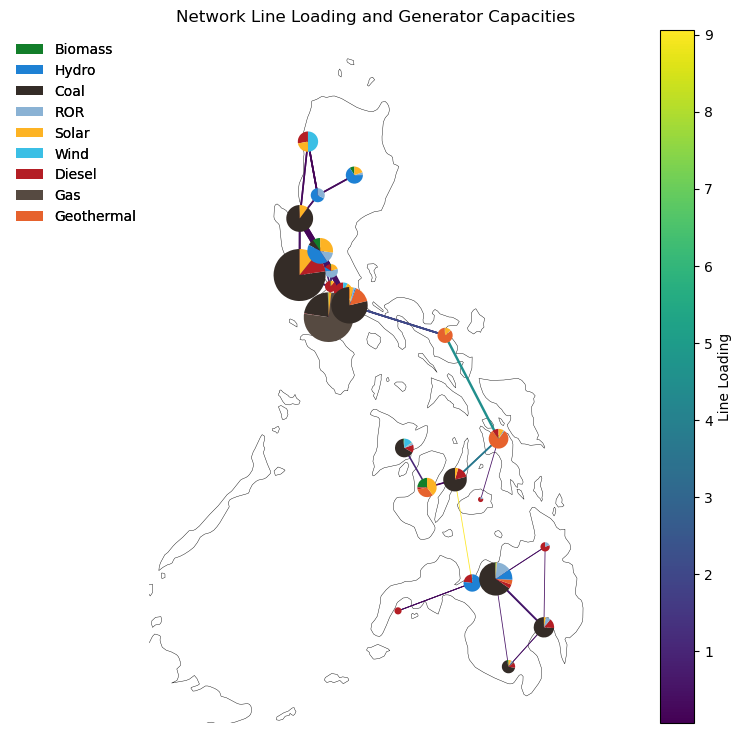

In [19]:
def plot_network(n,show_buses=True,show_loading=True,show_linecap=True):
    # Calculate bus generation capacities
    capacities = n.generators.groupby(["bus", "carrier"]).p_nom_opt.sum()
    
    # Calculate line loading
    n.lines['loading'] = n.lines_t.p0.abs().max() / n.lines.s_nom
    
    # Plotting the network with line loadings
    fig = plt.figure(figsize=(15, 9))
    ax = plt.axes(projection=ccrs.Mercator())
    
    n.plot(
        ax=ax,
        line_colors=n.lines['loading'] if show_loading==True else 10,
        line_cmap=plt.cm.viridis,
        line_widths=n.lines.s_nom.div(n.lines.s_nom.max()/.04e2)  if show_linecap==True else 10,  # Adjust this multiplier for better visibility
        bus_sizes=capacities / (capacities.max()*4)  if show_buses==True else 10, #Set to capacities if you want to see generator mix
        boundaries=(117, 127, 5, 20)  # Adjust the boundaries as per your region
    )

    if show_loading==True:
        # Add a colorbar for the line loading
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=n.lines['loading'].min(), vmax=n.lines['loading'].max()))
        sm._A = []
        plt.colorbar(sm, ax=ax, orientation='vertical', label='Line Loading')
    
    if show_buses==True:
        # Ensure that the colors and labels are aligned
        unique_carriers = n.generators.carrier.unique()
        carrier_colors = [n.carriers.loc[carrier, 'color'] for carrier in unique_carriers if carrier in n.carriers.index]

        # Add legend patches for the generators
        add_legend_patches(
            ax, carrier_colors, unique_carriers, legend_kw=dict(frameon=False, bbox_to_anchor=(0, 1))
        )
    
    plt.title('Network Line Loading and Generator Capacities')
    plt.show()

plot_network(n,show_buses=True,show_loading=True,show_linecap=True)

/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/ipykernel_52818/466612590.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



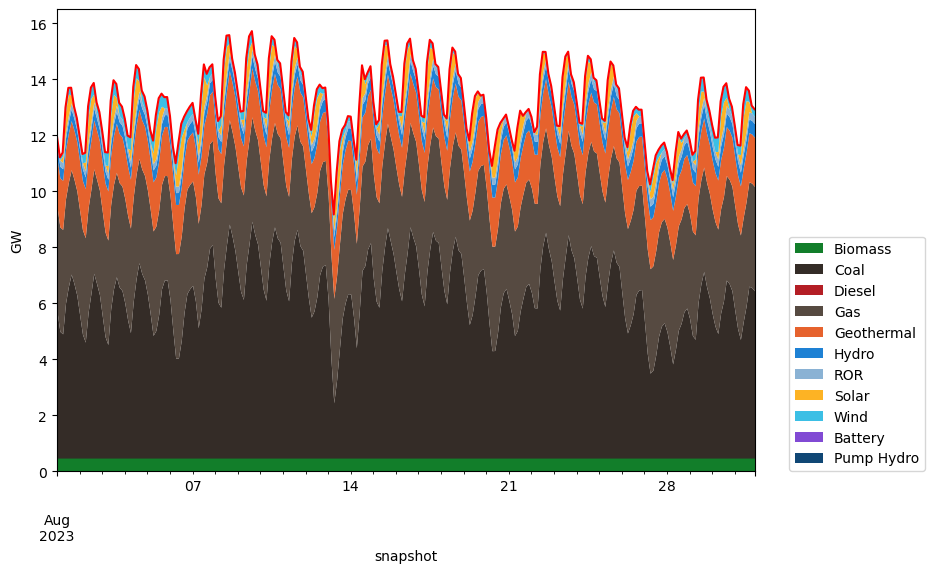

In [20]:
def plot_dispatch(n, time="2023"):
    # Sum the power generation by carrier and convert to GW
    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)

    # Include storage units if they exist
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.groupby(n.storage_units.carrier).sum().T.div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)

    # Include hydrogen store if they exist
    if not n.stores.empty:
        sto_h = n.stores_t.p.T.groupby(n.stores.carrier).sum().T.div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto_h], axis=1)

    fig, ax = plt.subplots(figsize=(9, 6))

    color = p_by_carrier.columns.map(n.carriers.color)

    # Plot positive values
    #print(p_by_carrier.where(p_by_carrier > 0).loc[time].head(24))
    p_by_carrier.where(p_by_carrier > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )

    # Plot negative values (charging)
    charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).loc[time]
    #print(charge.head(24))
    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
        )

    # Plot the load
    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="r")

    # Calculate the data range for setting y-limits
    max_peak = p_by_carrier.where(p_by_carrier > 0).loc[time].sum(axis=1).max()
    min_peak = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).sum(axis=1).min()
    
    # Set the y-axis limits with 10% padding
    y_max = max_peak * 1.05
    y_min = min_peak * 1.05 if min_peak < 0 else min_peak * 0

    ax.set_ylim(y_min, y_max)

    # Adjust the legend and labels
    plt.legend(loc=(1.05, 0))
    ax.set_ylabel("GW")
    plt.show()

plot_dispatch(n, time="2023-08")

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



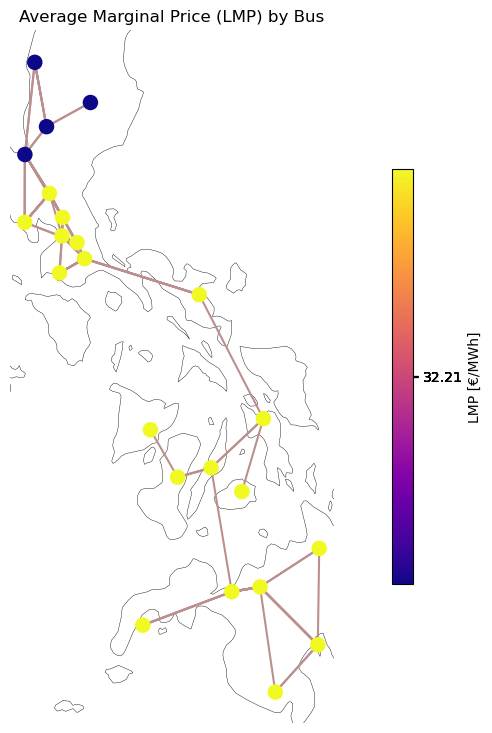

In [21]:
def plot_lmp(network, bus_carrier_filter=None, print_values=False):
    fig = plt.figure(figsize=(15, 9))
    ax = plt.axes(projection=ccrs.Mercator())

    # Calculate mean marginal price for each bus over all snapshots
    bus_lmp = network.buses_t.marginal_price.mean()

    # Optionally filter buses by carrier
    if bus_carrier_filter is not None:
        buses_to_plot = network.buses.index[network.buses.carrier.isin(bus_carrier_filter)]
        bus_lmp = bus_lmp.loc[buses_to_plot]

    if print_values:
        print("Bus LMP values:")
        print(bus_lmp)

    if bus_lmp.empty:
        print("No buses to plot after filtering. Please check the bus_carrier_filter or the network data.")
        return

    # Normalize color scale to the data range
    norm = plt.Normalize(vmin=bus_lmp.min(), vmax=bus_lmp.max())

    m=network.copy()
    m.buses= m.buses.loc[bus_lmp.index]  # Filter buses in the network to match bus_lmp

    m.plot(
        ax=ax,
        bus_colors=bus_lmp,
        bus_cmap="plasma",
        bus_norm=norm,
    )

    # Create the colorbar with correct normalization and boundaries
    sm = mpl.cm.ScalarMappable(cmap="plasma", norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label="LMP [€/MWh]", shrink=0.6)
    ticks = np.linspace(bus_lmp.min(), bus_lmp.max(), num=6)
    cbar.set_ticks(ticks)
    # Set the min and max as the limits of the tick labels
    cbar.set_ticklabels([f"{v:.2f}" for v in ticks])
    plt.title("Average Marginal Price (LMP) by Bus")
    plt.show()


plot_lmp(n, bus_carrier_filter=["AC"], print_values=False) #bus_carrier_filter=["AC", "Hydrogen"] 

/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/ipykernel_52818/3002366324.py:5: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



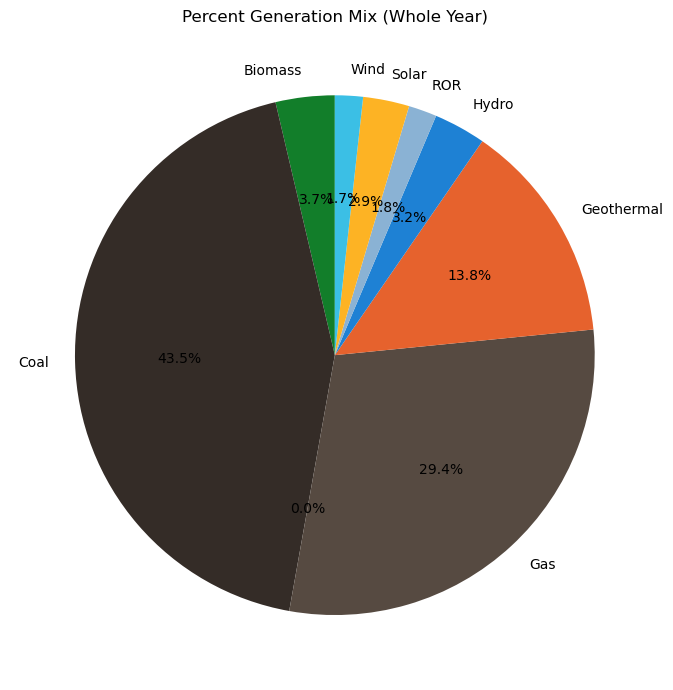

In [22]:
def plot_generation_mix_pie(network):
    """
    Plot the percent generation mix for the whole year by carrier as a pie chart.
    """
    gen_mix = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum().sum()
    gen_mix_percent = gen_mix / gen_mix.sum() * 100

    plt.figure(figsize=(7, 7))
    colors = [
        network.carriers.loc[carrier, 'color']
        if carrier in network.carriers.index and 'color' in network.carriers.columns else None
        for carrier in gen_mix_percent.index
    ]
    gen_mix_percent.plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)
    plt.ylabel('')
    plt.title('Percent Generation Mix (Whole Year)')
    plt.tight_layout()
    plt.show()

plot_generation_mix_pie(n)

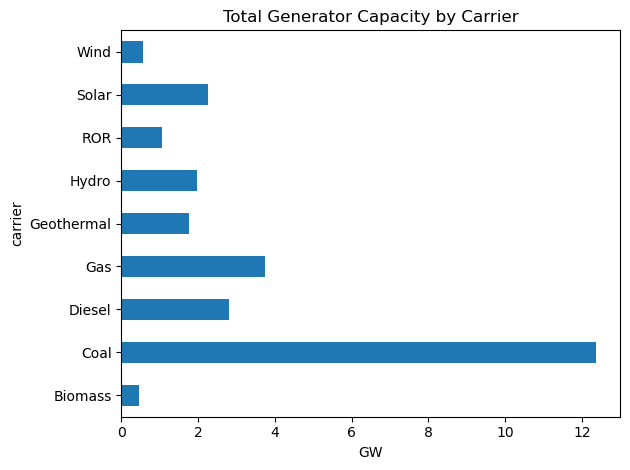

In [23]:
def plot_generator_capacity_by_carrier(network):
    """
    Plot total generator capacity by carrier for a given PyPSA network.
    """
    network.generators.groupby("carrier").p_nom_opt.sum().div(1e3).plot.barh()
    plt.xlabel("GW")
    plt.title("Total Generator Capacity by Carrier")
    plt.tight_layout()
    plt.show()

plot_generator_capacity_by_carrier(n)

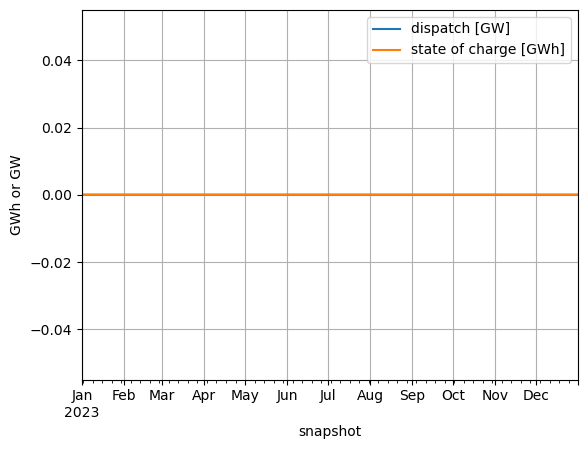

In [24]:
def plot_storage_dispatch(network, include_stores=True, carrier=None):
    """
    Plot storage dispatch and state of charge for a selected storage carrier.
    If carrier is None, plot the sum across all storage units (and stores if include_stores=True).
    """
    fig, ax = plt.subplots()

    # StorageUnits
    if carrier is not None:
        mask_su = network.storage_units.carrier == carrier
        storage_names = network.storage_units.index[mask_su]
        p_storage = network.storage_units_t.p[storage_names].sum(axis=1).div(1e3)
        if hasattr(network.storage_units_t, "state_of_charge"):
            state_of_charge = network.storage_units_t.state_of_charge[storage_names].sum(axis=1).div(1e3)
        else:
            state_of_charge = None
        label_prefix = f"{carrier} "
    else:
        p_storage = network.storage_units_t.p.sum(axis=1).div(1e3)
        if hasattr(network.storage_units_t, "state_of_charge"):
            state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1).div(1e3)
        else:
            state_of_charge = None
        label_prefix = ""

    # Stores (optional)
    if include_stores and not network.stores.empty:
        if carrier is not None:
            mask_store = network.stores.carrier == carrier
            store_names = network.stores.index[mask_store]
            p_store = network.stores_t.p[store_names].sum(axis=1).div(1e3)
            if hasattr(network.stores_t, "e"):
                soc_store = network.stores_t.e[store_names].sum(axis=1).div(1e3)
            else:
                soc_store = None
        else:
            p_store = network.stores_t.p.sum(axis=1).div(1e3)
            if hasattr(network.stores_t, "e"):
                soc_store = network.stores_t.e.sum(axis=1).div(1e3)
            else:
                soc_store = None

        # Add store data to storage data
        p_storage = p_storage.add(p_store, fill_value=0)
        if state_of_charge is not None and soc_store is not None:
            state_of_charge = state_of_charge.add(soc_store, fill_value=0)
        elif soc_store is not None:
            state_of_charge = soc_store

    p_storage.plot(label=f"{label_prefix}dispatch [GW]", ax=ax)
    if state_of_charge is not None:
        state_of_charge.plot(label=f"{label_prefix}state of charge [GWh]", ax=ax)

    ax.grid()
    ax.legend()
    ax.set_ylabel("GWh or GW")
    plt.show()

# Example usage:
plot_storage_dispatch(n)

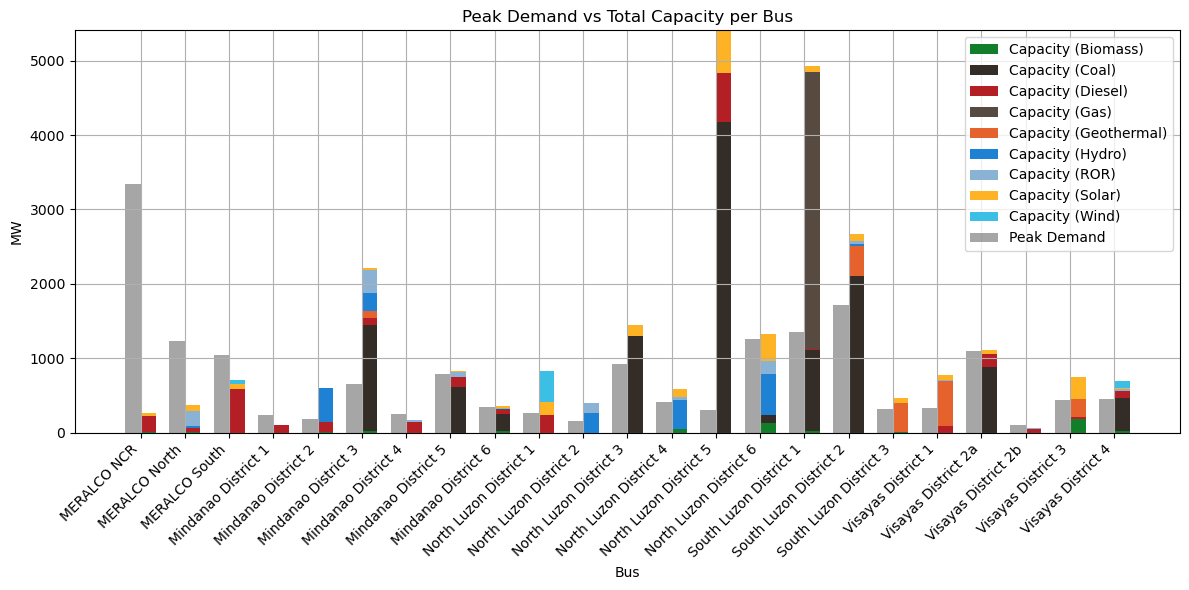

In [25]:
def plot_peak_demand_vs_capacity(network, stack_carrier=False):
    # Calculate the maximum hourly demand per bus
    max_demand_per_bus = network.loads_t.p_set.max()
    max_demand_per_bus.name = "Max Demand"

    # Calculate the total available capacity per bus and carrier
    capacity_by_bus_carrier = network.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().unstack(fill_value=0)
    total_capacity_per_bus = capacity_by_bus_carrier.sum(axis=1)
    total_capacity_per_bus.name = "Total Capacity"

    # Combine the data into a DataFrame and keep only buses with demand or capacity
    capacity_vs_demand = pd.concat([max_demand_per_bus, total_capacity_per_bus], axis=1).fillna(0)
    capacity_vs_demand = capacity_vs_demand.loc[(capacity_vs_demand["Max Demand"] > 0) | (capacity_vs_demand["Total Capacity"] > 0)]

    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    bar_positions = np.arange(len(capacity_vs_demand))

    if stack_carrier:
        # Plot stacked capacity by carrier
        carriers = [c for c in capacity_by_bus_carrier.columns if c in network.carriers.index]
        bottom = np.zeros(len(capacity_vs_demand))
        for carrier in carriers:
            values = capacity_by_bus_carrier.reindex(capacity_vs_demand.index).get(carrier, 0)
            color = network.carriers.loc[carrier, 'color'] if 'color' in network.carriers.columns else None
            ax.bar(bar_positions + bar_width/2, values, bar_width, label=f'Capacity ({carrier})', bottom=bottom, color=color)
            bottom += values.values

        # Plot demand as a single bar
        ax.bar(bar_positions - bar_width/2, capacity_vs_demand["Max Demand"], bar_width, label='Peak Demand', color='gray', alpha=0.7)
    else:
        # Plot total demand as a single bar
        ax.bar(bar_positions - bar_width/2, capacity_vs_demand["Max Demand"], bar_width, label='Peak Demand', color='gray', alpha=0.7)
        # Plot total capacity as a single bar
        ax.bar(bar_positions + bar_width/2, capacity_vs_demand["Total Capacity"], bar_width, label='Total Capacity', color='tab:blue')

    ax.set_xlabel('Bus')
    ax.set_ylabel('MW')
    ax.set_title('Peak Demand vs Total Capacity per Bus')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(capacity_vs_demand.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

plot_peak_demand_vs_capacity(n, stack_carrier=True)


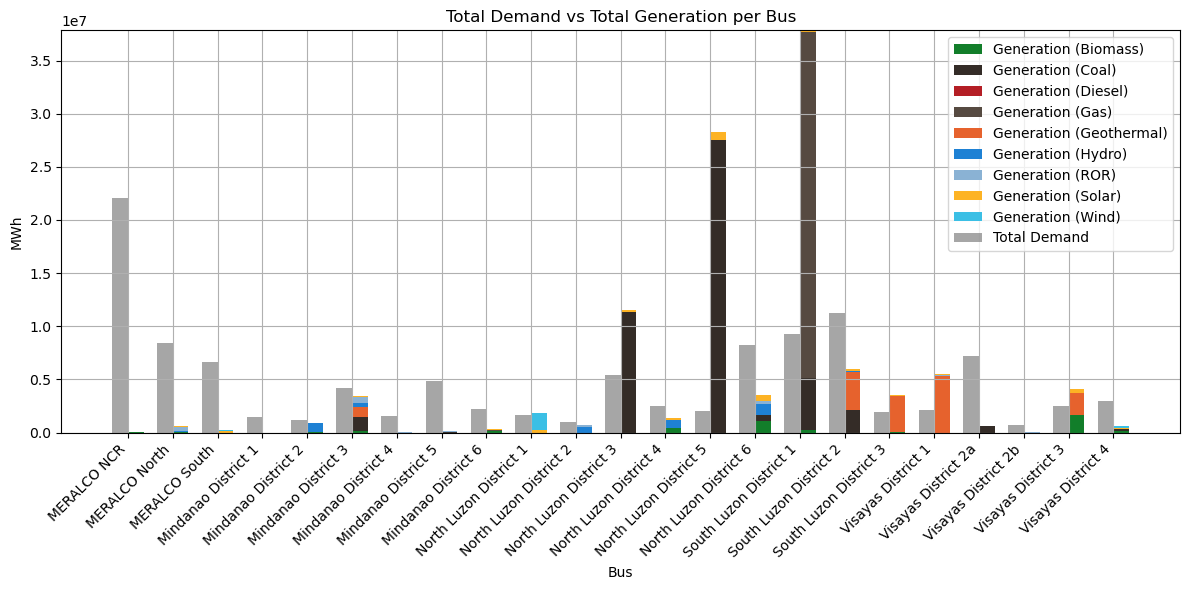

In [26]:
def plot_total_demand_vs_generation(network, temp_reso=1, stack_carrier=False):
    # Calculate the total demand per bus
    total_demand_per_bus = network.loads_t.p_set.sum()*temp_reso
    total_demand_per_bus.name = "Total Demand"

    # Calculate the total available capacity per bus and carrier
    generation_by_bus_carrier = network.generators[['bus', 'carrier']].assign(total_generation=network.generators_t.p.sum()).groupby(['bus', 'carrier'])['total_generation'].sum().unstack(fill_value=0)*temp_reso
    total_generation_per_bus = generation_by_bus_carrier.sum(axis=1)
    total_generation_per_bus.name = "Total Generation"

    # Combine the data into a DataFrame and keep only buses with demand or capacity
    generation_vs_demand = pd.concat([total_demand_per_bus, total_generation_per_bus], axis=1).fillna(0)
    generation_vs_demand = generation_vs_demand.loc[(generation_vs_demand["Total Demand"] > 0) | (generation_vs_demand["Total Generation"] > 0)]

    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    bar_positions = np.arange(len(generation_vs_demand))

    if stack_carrier:
        # Plot stacked generation by carrier
        carriers = [c for c in generation_by_bus_carrier.columns if c in network.carriers.index]
        bottom = np.zeros(len(generation_vs_demand))
        for carrier in carriers:
            values = generation_by_bus_carrier.reindex(generation_vs_demand.index).get(carrier, 0)
            color = network.carriers.loc[carrier, 'color'] if 'color' in network.carriers.columns else None
            ax.bar(bar_positions + bar_width/2, values, bar_width, label=f'Generation ({carrier})', bottom=bottom, color=color)
            bottom += values.values

        # Plot demand as a single bar
        ax.bar(bar_positions - bar_width/2, generation_vs_demand["Total Demand"], bar_width, label='Total Demand', color='gray', alpha=0.7)
    else:
        # Plot total demand as a single bar
        ax.bar(bar_positions - bar_width/2, generation_vs_demand["Total Demand"], bar_width, label='Total Demand', color='gray', alpha=0.7)
        # Plot total capacity as a single bar
        ax.bar(bar_positions + bar_width/2, generation_vs_demand["Total Generation"], bar_width, label='Total Generation', color='tab:blue')

    ax.set_xlabel('Bus')
    ax.set_ylabel('MWh')
    ax.set_title('Total Demand vs Total Generation per Bus')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(generation_vs_demand.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

plot_total_demand_vs_generation(n, temp_reso=3, stack_carrier=True)


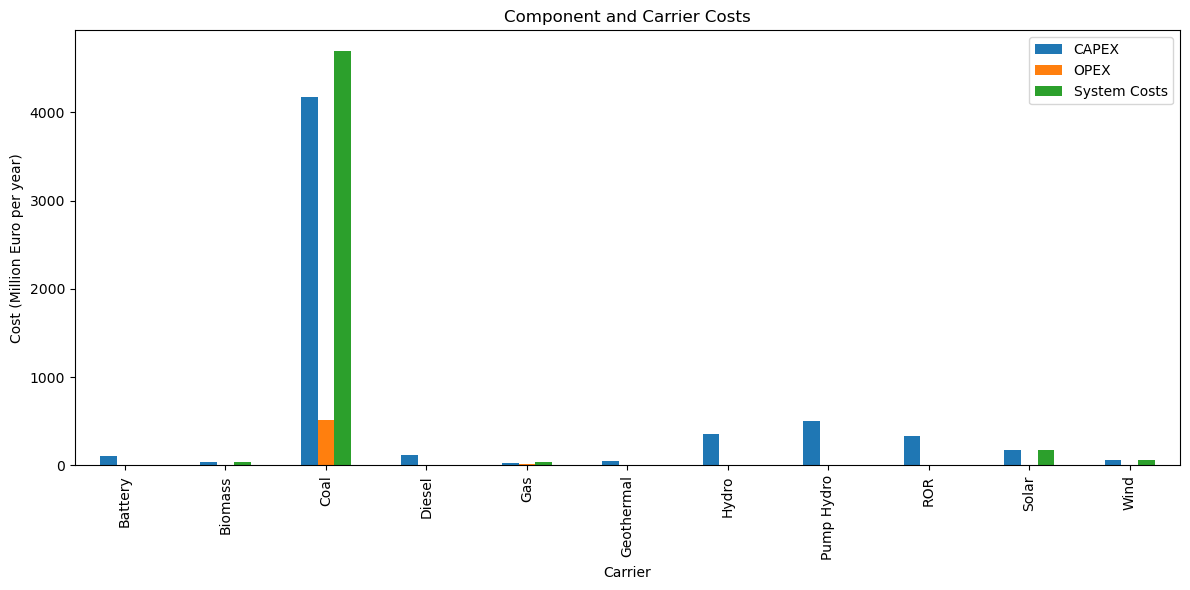

Total System Cost: 6475.54 Million Euro per Year


In [27]:
def combined_cost_plot(network, stacked=False):
    def system_cost(n):
        tsc = n.statistics.capex() + n.statistics.opex()
        return tsc.groupby(level=1).sum().div(1e6)  # million €/a

    def capex_data(n):
        return n.statistics.capex().groupby(level=1).sum().div(1e6)  # million €/a

    def opex_data(n):
        return n.statistics.opex().groupby(level=1).sum().div(1e6)  # million €/a

    capex = capex_data(network)
    opex = opex_data(network)
    system_costs = system_cost(network)

    all_carriers = capex.index.union(opex.index).union(system_costs.index)
    capex = capex.reindex(all_carriers).fillna(0)
    opex = opex.reindex(all_carriers).fillna(0)
    system_costs = system_costs.reindex(all_carriers).fillna(0)

    combined_df = pd.DataFrame({
        'CAPEX': capex,
        'OPEX': opex,
        'System Costs': system_costs
    })

    fig, ax = plt.subplots(figsize=(12, 6))
    if stacked:
        combined_df[['CAPEX', 'OPEX']].plot(kind='bar', stacked=True, ax=ax)
        ax.plot(combined_df.index, combined_df['System Costs'], color='black', marker='o', label='System Costs')
    else:
        combined_df.plot(kind='bar', ax=ax)

    ax.set_title('Component and Carrier Costs')
    ax.set_ylabel('Cost (Million Euro per year)')
    ax.set_xlabel('Carrier')
    plt.tight_layout()
    plt.legend()
    plt.show()

    total_capex = capex.sum()
    total_opex = opex.sum()
    total_costs = total_capex + total_opex
    print(f"Total System Cost: {total_costs:.2f} Million Euro per Year")

combined_cost_plot(n, stacked=False)

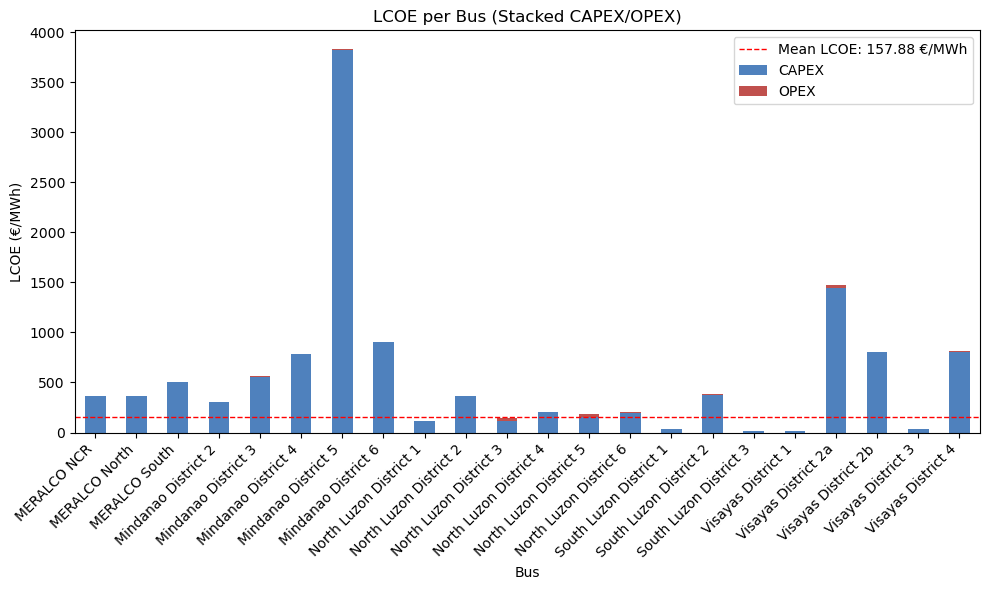

In [28]:
def plot_lcoe_by_bus(network, show_components=False):
    # Calculate annual energy production per generator (MWh)
    annual_energy_production = network.generators_t.p.sum(axis=0)
    # Aggregate annual energy production by bus
    annual_energy_production_by_bus = annual_energy_production.groupby(network.generators.bus).sum()
    # Prepare DataFrames for CAPEX and OPEX per bus
    buses = network.buses.index
    capex_by_bus = pd.Series(0.0, index=buses)
    opex_by_bus = pd.Series(0.0, index=buses)
    total_costs_by_bus = pd.Series(0.0, index=buses)
    for bus in buses:
        generators_at_bus = network.generators[network.generators.bus == bus]
        for gen in generators_at_bus.index:
            capex = network.generators[network.generators.bus == bus].at[gen, 'capital_cost']
            opex = network.generators[network.generators.bus == bus].at[gen, 'marginal_cost']
            p_nom_opt = network.generators.at[gen, 'p_nom_opt']
            capex_by_bus[bus] += capex * p_nom_opt
            opex_by_bus[bus] += opex * annual_energy_production[gen]
            total_costs_by_bus[bus] += capex * p_nom_opt + opex * annual_energy_production[gen]
    # Calculate LCOE per bus, exclude buses with zero annual energy production
    LCOE_by_bus = total_costs_by_bus / annual_energy_production_by_bus
    LCOE_by_bus = LCOE_by_bus.replace([float('inf'), -float('inf')], pd.NA).dropna()
    mean_LCOE = (LCOE_by_bus * annual_energy_production_by_bus.reindex(LCOE_by_bus.index)).sum() / annual_energy_production_by_bus.reindex(LCOE_by_bus.index).sum()
    if show_components:
        # Compute component LCOEs
        capex_lcoe = capex_by_bus / annual_energy_production_by_bus
        opex_lcoe = opex_by_bus / annual_energy_production_by_bus
        capex_lcoe = capex_lcoe.reindex(LCOE_by_bus.index)
        opex_lcoe = opex_lcoe.reindex(LCOE_by_bus.index)
        df = pd.DataFrame({'CAPEX': capex_lcoe, 'OPEX': opex_lcoe})
        ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#4F81BD', '#C0504D'])
        ax.set_ylabel('LCOE (€/MWh)')
        ax.set_title('LCOE per Bus (Stacked CAPEX/OPEX)')
        ax.axhline(mean_LCOE, color='red', linestyle='--', linewidth=1, label=f'Mean LCOE: {mean_LCOE:.2f} €/MWh')
        ax.set_xticklabels(df.index, rotation=45, ha='right')
        ax.legend()
        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = LCOE_by_bus.plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title('LCOE per Bus')
        ax.set_xlabel('Bus')
        ax.set_ylabel('LCOE (€/MWh)')
        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', color='black', rotation=90)
        ax.axhline(mean_LCOE, color='red', linestyle='--', linewidth=1, label=f'Mean LCOE: {mean_LCOE:.2f} €/MWh')
        ax.set_xticklabels(LCOE_by_bus.index, rotation=45, ha='right')
        ax.legend()
        plt.tight_layout()
        plt.show()

plot_lcoe_by_bus(n, show_components=True)

### 06 Future Case Scenario Simulations with Projected Demand Growth, CO2 Reduction and Hydrogen Sector Coupling

This section explores future scenarios for the Philippine power system by projecting demand, technology costs, and system configurations to future years. It includes functions for scenario analysis, demand forecasting, and the evaluation of key metrics such as LCOE, emissions, and generation mix under different policy and technology pathways. The workflow enables comparison of baseline and future cases to inform planning and decision-making.

**IMPORTANT NOTES BEFORE RUNNING THIS SECTION:** 

1. Currently, this section only works when the `AGGREGATE_BUSES = 'custom_TDP2'` since the future projection data for the demand were only available for NGCP Transmission Districts. 

2. Since each scenario requires too much memory space, it is advice to run them individually and store them as `{scenario name}.nc` file first. To analyses scenario results, import the PyPSA network, then use the visualization tools available here.

#### 06.01 Code Functions for Projection to Future Scenarios

This section provides the core Python functions used to project the PyPSA-PH network into future scenarios. These functions enable the simulation of demand growth, technology evolution, CO₂ reduction targets, and sector coupling (e.g., hydrogen integration). Each function is documented below with its purpose, inputs, and outputs.

---

**Function Definitions:**

- **restart_network(n):**  
    *Purpose:* Resets a PyPSA network object by removing all buses and associated components, preparing it for reconstruction.  
    *Inputs:*  
        - `n`: PyPSA Network object to be cleared.  
    *Outputs:*  
        - None (modifies the network in place).

- **project_network(n, y, co2_red=0, add_gen_tech, add_store_tech, H2_SU, H2_S, H2_p_set, load_growth_factor):**  
    *Purpose:* Projects the given network to a future year, optionally adding new technologies, enforcing CO₂ constraints, and integrating hydrogen sector coupling.  
    *Inputs:*  
        - `n`: Base PyPSA Network object.  
        - `y`: Target year for cost reference and demand projection (int).  
        - `co2_red`: Fractional CO₂ reduction target (float, 0–1).  
        - `add_gen_tech`: List of generator technologies to add (list of str).  
        - `add_store_tech`: List of storage technologies to add (list of str).  
        - `H2_SU`: Enable hydrogen sector coupling (bool).  
        - `H2_S`: Add synthetic hydrogen demand (bool).  
        - `H2_p_set`: Value for hydrogen demand per bus (float).  
        - `load_growth_factor`: Optional custom load growth factor (Series or None).  
    *Outputs:*  
        - `n_new`: Projected PyPSA Network object for the future scenario.

- **solup_net(n):**  
    *Purpose:* Optimizes the network and removes components with zero optimal capacity, returning network statistics.  
    *Inputs:*  
        - `n`: PyPSA Network object to optimize.  
    *Outputs:*  
        - Network statistics (DataFrame).

- **total_generation(n):**  
    *Purpose:* Calculates the average annual generation per carrier in GW.  
    *Inputs:*  
        - `n`: PyPSA Network object.  
    *Outputs:*  
        - DataFrame with columns: `Carrier`, `Generation_GW`.

- **total_emissions(n):**  
    *Purpose:* Computes total CO₂ emissions per carrier in Mt CO₂.  
    *Inputs:*  
        - `n`: PyPSA Network object.  
    *Outputs:*  
        - DataFrame with columns: `Carrier`, `Emission_tCO2/MWh_th`.

- **calc_LCOE(n):**  
    *Purpose:* Calculates the Levelized Cost of Electricity (LCOE) for the network.  
    *Inputs:*  
        - `n`: PyPSA Network object.  
    *Outputs:*  
        - List: `[total_capex, total_opex, total_electricity, LCOE, LCOE_PHP_MWh]`.


These functions form the basis for scenario analysis, enabling systematic exploration of future Philippine power system pathways.

In [29]:
def restart_network(n):
    # Remove all buses, which will automatically remove connected components like generators, lines, etc.
    n.mremove("Bus", n.buses.index)
    
    # Remove all generators
    n.mremove("Generator", n.generators.index)
    
    # Remove all loads
    n.mremove("Load", n.loads.index)
    
    # Remove all lines
    n.mremove("Line", n.lines.index)

    # Remove all links
    n.mremove("Link", n.links.index)
    
    # Remove all storage units
    n.mremove("StorageUnit", n.storage_units.index)

    # Remove all stores
    n.mremove("Store", n.stores.index)
    
    # Remove all other components (optional)
    n.mremove("GlobalConstraint", n.global_constraints.index)
    n.mremove("Carrier", n.carriers.index)
    n.mremove("SubNetwork", n.sub_networks.index)

In [30]:
def project_network(n, y, re_percent=None , co2_red=None, add_gen_tech=["Solar", "Wind", "Coal"], add_store_tech=["Battery"],  H2_SU=False, H2_S=False, H2_p_set=0, load_growth_factor=None):
    n_new = pypsa.Network()

    # Restart n_new
    restart_network(n_new)

    # Add snapshots
    n_new.set_snapshots(n.snapshots.copy())

    # Copy buses
    bus_data = n.buses[['x', 'y', 'v_nom', 'carrier']].copy()
    for bus in bus_data.index:
        n_new.add("Bus", bus, x=bus_data.at[bus, 'x'], y=bus_data.at[bus, 'y'], v_nom=bus_data.at[bus, 'v_nom'], carrier=bus_data.at[bus, 'carrier'])

    # Copy and update loads and loads_t, else apply load growth factor
    present_load = n.loads_t['p_set'].mean(axis=0).copy()
    if load_growth_factor is not None:
        load_growth = present_load*load_growth_factor
    else:
        load_growth = present_load if y <= 2020 else future_loads.loc[present_load.index, str(y)]/present_load 
        
    for i in load_growth.index:
        load_growth[i] = load_growth[i] if load_growth[i] >= 1 else 1

    for bus in present_load.index:
        n_new.add("Load", bus, bus=bus)
        n_new.loads_t.p_set.loc[:, bus] = n.loads_t.p_set.loc[:, bus].copy()*load_growth[bus]

    # Copy generators and generators_t
    for i, gen in n.generators.iterrows():
        if gen['lifetime'] > y:
            n_new.add("Generator", i, bus=gen['bus'], p_nom=gen['p_nom_opt'], 
                      carrier=gen['carrier'], efficiency=gen['efficiency'],
                      capital_cost=gen['capital_cost'], marginal_cost=gen['marginal_cost'], 
                      lifetime=gen['lifetime'], p_nom_extendable=False)
    n_new.generators_t.p_max_pu = n.generators_t.p_max_pu.loc[:, n_new.generators.index].copy()

    # Copy storage units
    for i, su in n.storage_units.iterrows():
        if su['lifetime'] > y:
            n_new.add("StorageUnit", i, bus=su['bus'], p_nom=su['p_nom_opt'], carrier=su['carrier'], max_hours=su['max_hours'], efficiency_store=su['efficiency_store'], efficiency_dispatch=su['efficiency_dispatch'],capital_cost=su['capital_cost'], marginal_cost=su['marginal_cost'], lifetime=su['lifetime'], p_nom_extendable=False)

    # Copy stores
    for i, s in n.stores.iterrows():
        if s['lifetime'] > y:
            n_new.add("Store", i, bus=s['bus'], e_nom=s['e_nom_opt'], carrier=s['carrier'], capital_cost=s['capital_cost'], marginal_cost=s['marginal_cost'], lifetime=s['lifetime'], e_nom_extendable=False)

    # Copy carriers
    carrier_data = n.carriers[['co2_emissions', 'color']].copy()
    for carrier in carrier_data.index:
        n_new.add("Carrier", carrier, co2_emissions=carrier_data.at[carrier, 'co2_emissions'], color=carrier_data.at[carrier, 'color'])

    # Copy lines
    for i, line in n.lines.iterrows():
        n_new.add("Line", i, bus0=line['bus0'], bus1=line['bus1'], x=line['x'], r=line['r'], s_nom=line['s_nom_opt'], s_nom_extendable=True)

    # Copy links
    for i, link in n.links.iterrows():
        if link['lifetime'] > y:
            n_new.add("Link", i, bus0=link['bus0'], bus1=link['bus1'], carrier=link['carrier'], efficiency=link['efficiency'] , marginal_cost=link['marginal_cost'] , capital_cost=link['capital_cost'] ,p_nom=link['p_nom_opt'], p_nom_extendable=False)

    # Add new capacities (e.g., generators, storage units)
    costs_data = get_costs_data(y)
    tech_map = {"Gas": "gas boiler steam", "Solar": "solar", "Wind": "onwind", "Diesel": "oil", "Coal": "coal", "Hydro": "hydro", "Geothermal": "geothermal", "Biomass": "solid biomass boiler steam", "ROR": "ror", "Battery": "battery storage", "Pump Hydro": "Pumped-Storage-Hydro-store"}

    # Update cost data of existing generators
    for carrier in n_new.generators.carrier.unique():
        tech = tech_map.get(carrier)
        # n_new.generators.loc[n_new.generators['carrier'] == carrier, 'efficiency'] = costs_data.at[tech, "efficiency"]
        n_new.generators.loc[n_new.generators['carrier'] == carrier, 'marginal_cost'] = costs_data.at[tech, "marginal_cost"]
        # n_new.generators.loc[n_new.generators['carrier'] == carrier, 'capital_cost'] = costs_data.at[tech, "capital cost"]
    
    # Update cost data of storage units
    for carrier in n_new.storage_units.carrier.unique():
        tech = tech_map.get(carrier)
        #n_new.storage_units.loc[n_new.storage_units['carrier'] == carrier, 'efficiency_dispatch'] = costs_data.at[tech, "efficiency"]
        #n_new.storage_units.loc[n_new.storage_units['carrier'] == carrier, 'efficiency_store'] = costs_data.at[tech, "efficiency"]
        n_new.storage_units.loc[n_new.storage_units['carrier'] == carrier, 'marginal_cost'] = costs_data.at[tech, "marginal_cost"]
        #n_new.storage_units.loc[n_new.storage_units['carrier'] == carrier, 'capital_cost'] = costs_data.at[tech, "capital_cost"]
    
    if H2_SU == True:
        if "Hydrogen" not in n_new.carriers.index:
            n_new.add("Carrier", "Hydrogen", co2_emissions=0, color="#b01787")

    if H2_S == True:
        #Building main H2 bus for national H2 demand
        if "main_H2" not in n_new.buses.index:
            n_new.add("Bus", "main_H2",
                        x=n.buses.x.mean(),
                        y=n.buses.y.mean(),
                        carrier="Hydrogen")  
            #Add national H2 demand on main_H2 bus
            n_new.add("Load", f"main_H2_load", bus="main_H2", carrier="Hydrogen", p_set=H2_p_set)  # in MW_H2, could be assumed 258MW at the moment to supply off-grid MW_diesel demand divided among all H2 buses
        else:
            n_new.loads.loc["main_H2_load", "p_set"] = H2_p_set


    for bus in n_new.buses.index[n_new.buses['carrier'].isin(["AC"])]:

        #Addition of Storage Units
        for carrier in add_store_tech: # ["Battery", "Pump Hydro"]
            tech = tech_map[carrier]
            n_new.add("StorageUnit", 
                      f"{bus}_{carrier}_{y}", 
                      bus=bus, 
                      carrier=carrier, 
                      max_hours= 4 if carrier=="Battery" else 6, 
                      efficiency_dispatch=costs_data.at[tech, "efficiency"], 
                      efficiency_store=costs_data.at[tech, "efficiency"], 
                      capital_cost=costs_data.at[tech, "capital_cost"], 
                      marginal_cost=costs_data.at[tech, "marginal_cost"], 
                      lifetime=y + costs_data.at[tech, "lifetime"], 
                      p_nom_extendable=True)
                #Addition of Generators
        for carrier in add_gen_tech: # ["Solar", "Wind", "Coal", "Gas", "Diesel", "Hydro", "ROR", "Biomass", "Geothermal"]
            tech = tech_map[carrier]
            n_new.add("Generator", 
                      f"{bus}_{carrier}_{y}", 
                      bus=bus, carrier=carrier, 
                      efficiency=costs_data.at[tech, "efficiency"], 
                      marginal_cost=costs_data.at[tech, "marginal_cost"], 
                      capital_cost=costs_data.at[tech, "capital_cost"], 
                      lifetime=y + costs_data.at[tech, "lifetime"], 
                      p_nom_extendable=True)
            if carrier in ["Solar", "Wind"]:
                n_new.generators_t.p_max_pu[f"{bus}_{carrier}_{y}"] = district_RE[f"{bus}_{carrier}"]
            else:
                n_new.generators_t.p_max_pu[f"{bus}_{carrier}_{y}"] = np.ones(len(n.generators_t.p_max_pu))

        #Addition of Hydrogen Assemblies: H2_SU allows building H2 assemblies to support grid, H2_S allows building H2 assemblies to supply H2 gas demand of the country
        if H2_SU or H2_S == True:
            if f"{bus}_H2" not in n_new.buses.index:
                #Hydrogen bus
                n_new.add("Bus", f"{bus}_H2", 
                          x=n.buses.at[bus, 'x'], 
                          y=n.buses.at[bus, 'y'],
                          carrier="Hydrogen") 
                #Electrolyzer Link
                n_new.add(
                    "Link",
                    f"{bus}_H2_electrolysis",
                    bus0=bus,
                    bus1=f"{bus}_H2",
                    carrier="Hydrogen",
                    p_nom_extendable=True,
                    efficiency=costs_data.at["electrolysis", "efficiency"],
                    capital_cost=costs_data.at["electrolysis", "capital_cost"],
                    marginal_cost=costs_data.at["electrolysis", "marginal_cost"],
                    lifetime=y + costs_data.at["electrolysis", "lifetime"]) 
                #Hydrogen Store Tank
                n_new.add(
                    "Store",
                    f"{bus}_H2_storage",
                    bus=f"{bus}_H2",
                    carrier="Hydrogen",
                    capital_cost=costs_data.at["hydrogen storage tank type 1 including compressor", "capital_cost"], 
                    marginal_cost=costs_data.at["hydrogen storage tank type 1 including compressor", "marginal_cost"],
                    lifetime=y + costs_data.at["hydrogen storage tank type 1 including compressor", "lifetime"],
                    e_nom_extendable=True,
                    e_cyclic=True)  
                #Fuel Cell Link, only activates if H2_SU is True, allowing H2 to be converted back to electricity
                if H2_SU == True:
                    n_new.add(
                        "Link",
                        f"{bus}_H2_fuel cell",
                        bus0=f"{bus}_H2",
                        bus1=bus,
                        carrier="Hydrogen",
                        p_nom_extendable=True,
                        efficiency=costs_data.at["fuel cell", "efficiency"],
                        capital_cost=costs_data.at["fuel cell", "capital_cost"],
                        marginal_cost=costs_data.at["fuel cell", "marginal_cost"],
                        lifetime=y + costs_data.at["fuel cell", "lifetime"]) 
                #H2 Transport link from one H2 to main_H2 bus 
                if H2_S == True:
                    n_new.add("Link", f"{bus}_H2_transport",
                            bus0=f"{bus}_H2",
                            bus1="main_H2",
                            carrier="Hydrogen",
                            p_nom_extendable=True,
                            efficiency=1.0,  # Assuming no loses during transport
                            capital_cost=costs_data.at["H2 (l) transport ship", "capital_cost"],
                            marginal_cost=costs_data.at["H2 (l) transport ship", "marginal_cost"],
                            lifetime=y + costs_data.at["H2 (l) transport ship", "lifetime"])

    # Add global constraint on CO2 emission
    if co2_red is not None:   
        reference_emissions = (n.generators_t['p'] / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions)).sum().sum()
        n_new.add("GlobalConstraint", "CO2Limit", carrier_attribute="co2_emissions", sense="<=", constant=reference_emissions * (1 - co2_red)) #type='primary energy'  Add

    # Add global constraint on minimum renewable energy share
    if re_percent is not None:
        # Identify renewable carriers
        renewable_carriers = ["Solar", "Wind", "Hydro", "ROR", "Biomass", "Geothermal"]
        # Map to carrier names in the network
        renewable_gens = n_new.generators.index[n_new.generators['carrier'].isin(renewable_carriers)]
        # Create an expression for total renewable generation
        re_expr = (n_new.generators_t['p_max_pu'][renewable_gens].multiply(n_new.generators.loc[renewable_gens, 'p_nom'], axis=1)).sum(axis=1).sum()
        # Create an expression for total generation
        total_expr = (n_new.generators_t['p_max_pu'].multiply(n_new.generators['p_nom'], axis=1)).sum(axis=1).sum()
        
        # Add global constraint for minimum RE share
        n_new.add("GlobalConstraint", "MaxREShare", sense=">=", constant=re_percent, 
                  type="primary_energy", 
                  expression=(re_expr / total_expr))

        # If brute force will be done to the previous scenario to ensure that it is the non-RE dispatchable generators who are being lessened in total generation share instead of RE which could have less ( note p <= p_nom_pu*p_nom)
        # n_new.add("GlobalConstraint", "MaxNonREShare", sense="<=", constant=re_percent, 
        #     type="primary_energy", 
        #     expression=((total_expr-re_expr) / total_expr))

        # Maximum brute force to obtain the exact RE_percent goal [It doesn't work with a sense of "==" and I think assumes maximum value immediately]
        # n_new.add("GlobalConstraint", "REShare", sense="==", constant=re_percent, 
        #           type="primary_energy", 
        #           expression=(re_expr / total_expr))


    return n_new

In [31]:
def solup_net(n):
# Optimize the network
    n.optimize(solver_name='gurobi')
    
    # Remove generators with zero p_nom_opt
    # Also remove generators_t with p_nom_opt zero
    n.generators = n.generators[n.generators['p_nom_opt'] > 0].copy()
    
    # Remove storage units with zero p_nom_opt
    n.storage_units = n.storage_units[n.storage_units['p_nom_opt'] > 0].copy()

    # Remove stores and hydrogen assemblies with zero p_nom_opt
    storeremove = n.stores[n.stores['e_nom_opt'] == 0].copy()
    n.buses = n.buses[~n.buses.index.isin(storeremove['bus'])].copy()
    n.links = n.links[~n.links.bus0.isin(storeremove['bus'])].copy()
    n.links = n.links[~n.links.bus1.isin(storeremove['bus'])].copy()
    n.stores = n.stores[n.stores['e_nom_opt'] != 0].copy()
    
    return n.statistics()

In [32]:
def total_generation(n):
    generation = n.generators_t.p.T.groupby(n.generators.carrier).sum().mean(axis=1).div(1e3) # in GWh_ave
    generation_df = generation.reset_index()
    generation_df.columns = ['Carrier', 'Generation_GWh']
    return generation_df

In [33]:
def total_emissions(n):
    # Calculate total CO2 emissions per carrier
    emissions = ((n.generators_t.p/n.generators.efficiency) * n.generators['carrier'].map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().div(1e6).sum(axis=1)  # in Mt CO₂
    emissions_df = emissions.reset_index()
    emissions_df.columns = ['Carrier', 'Emission_tCO2/MWh_th']
    return emissions_df

In [34]:
def calc_LCOE(n, exchange_rate=None):
    total_capex = n.statistics.capex(["Generator","StorageUnit","Store","Line","Link"]).sum()
    total_opex = n.statistics.opex(["Generator","StorageUnit","Store","Line","Link"]).sum()
    total_electricity = n.statistics.supply(["Generator"]).sum()
    LCOE = (total_capex + total_opex)/total_electricity
    LCOEdat=[total_capex, total_opex, total_electricity, LCOE, LCOE*exchange_rate if exchange_rate is not None else None]
    return LCOEdat

#### 06.02 Definition of Functions for Future Simulations

This section defines and documents the functions and scenario setups used for projecting the Philippine power system into the future. Five distinct future scenarios are explored to assess the impacts of demand growth, CO₂ reduction targets, and hydrogen sector coupling. These scenarios are constructed using the `project_network` function, which allows flexible configuration of technology additions, CO₂ constraints, and hydrogen integration. The results from these scenarios provide insights into the role of hydrogen, storage, and sector coupling in achieving deep decarbonization of the Philippine power system.

**NOTE:** Since each scenario requires too much memory space, it is advice to run them individually and store them as `{scenario name}.nc` file first. To analyses scenario results, import the desired future case PyPSA network on the next section, then use the visualization tools available there.

1. **nf_h**:  
    *Full Hydrogen Sector Coupling*  
    Projects the network to 2040 with 100% CO₂ reduction and enables hydrogen sector coupling (H₂ assemblies added at all buses). This scenario evaluates the system when hydrogen is integrated for flexibility and sector coupling, but without explicit hydrogen demand.

In [35]:
raise RuntimeError("Stopping execution here. Kindly read the instructions above on running this section of the code.")

RuntimeError: Stopping execution here. Kindly read the instructions above on running this section of the code.

In [ ]:
nf_h = project_network(n, y=2040, co2_red=1.0, H2_SU=True)
solup_net(nf_h)
nf_h.export_to_netcdf("results/PyPSA-PH_2040_H2.nc")

2. **nf_hs**:  
    *Hydrogen Sector Coupling with Synthetic Demand*  
    Similar to `nf_h`, but includes a synthetic hydrogen demand (H₂_S=True, H₂_p_set=250/4 MW per bus). This scenario represents the case where hydrogen is produced to meet a specified demand, such as for industry or export.

In [ ]:
raise RuntimeError("Stopping execution here. Kindly read the instructions above on running this section of the code.")

In [ ]:
nf_hs = project_network(n, y=2040, co2_red=1.0, H2_SU=True, H2_S=True, H2_p_set=250/4)
solup_net(nf_hs)
nf_h.export_to_netcdf("results/PyPSA-PH_2040_H2S.nc")

3. **nf_hsh**:  
    *Hydrogen Sector Coupling with Projected Export Demand*  
    Builds on `nf_hs` by scaling hydrogen demand according to projected export requirements (H₂_p_set grows with time). This scenario explores the impact of large-scale hydrogen production for export markets.

In [ ]:
raise RuntimeError("Stopping execution here. Kindly read the instructions above on running this section of the code.")

In [ ]:
nf_hsh = project_network(n, y=2040, co2_red=1.0, H2_SU=True, H2_S=True, H2_p_set=(250*(1.02**40))/4)
solup_net(nf_hsh)
nf_h.export_to_netcdf("results/PyPSA-PH_2040_H2SH.nc")

4. **nf_nh**:  
    *No Hydrogen Sector Coupling*  
    Projects the network to 2040 with 100% CO₂ reduction but without hydrogen sector coupling. This serves as a reference scenario to compare the effects of hydrogen integration.

In [ ]:
raise RuntimeError("Stopping execution here. Kindly read the instructions above on running this section of the code.")

In [ ]:
nf_nh = project_network(n, y=2040, co2_red=1.0)
solup_net(nf_nh)
nf_h.export_to_netcdf("results/PyPSA-PH_2040.nc")

5. **nf_oh**:  
    *Hydrogen Sector Coupling without Additional Storage*  
    Similar to `nf_h`, but disables the addition of new storage technologies (add_store_tech=[]). This scenario isolates the effect of hydrogen sector coupling without the influence of new battery or pumped hydro storage.

In [ ]:
raise RuntimeError("Stopping execution here. Kindly read the instructions above on running this section of the code.")

In [ ]:
nf_oh = project_network(n, y=2040, co2_red=1.0, add_store_tech=[], H2_SU=True)
solup_net(nf_oh)
nf_h.export_to_netcdf("results/PyPSA-PH_2040_OH.nc")

6. **nf_custom**:  
    *Define user custom future scenario*  
    Allow user to set their own parameter values for setting the future case scenario. This function also allows the user to perform **multi-year modeling** by taking the intermediate future scenario network output as the baseline network for the next iteration in modelling the succedding future scenario till the end of the planning period is reached. Rename the custom future scenario file as necessary.

In [ ]:
raise RuntimeError("Stopping execution here. Kindly read the instructions above on running this section of the code.")

In [ ]:
nf_custom = project_network(
    n=n, 
    y=2030, 
    re_percent=None,
    co2_red=None, 
    add_gen_tech=["Solar", "Wind", "Coal"], 
    add_store_tech=["Battery"],  
    H2_SU=False, 
    H2_S=False, 
    H2_p_set=0, 
    load_growth_factor=None)
solup_net(nf_custom)
nf_custom.export_to_netcdf("results/PyPSA-PH_custom.nc")

7. **Looping**:  
    Allow user to loop the custom scenario function for multiple years with the same scenario paramters.

In [ ]:
years = [2030, 2040, 2050] #Loop only up to four year scenarios to not crash the memory
NDC = {2030: 0.41, 2040: 0.65, 2050: 0.73} #Nationally Determined Contributions for CO2 reduction in the Philippines
PEP = {2030: 0.35, 2040: 0.5, 2050: 0.65} #Philippine Energy Plan for Renewable Energy share, 2050 extrapolated from 2040
H2_load_projection = {2030: 250, 2040: 400, 2050: 800} #H2 load projection in MW, 2050 extrapolated from 2040
scenario_name = "SUSH2_PEPreshare_new"

n_store = n.copy() # Copy of base network

output_dir = f"results/{scenario_name}"
os.makedirs(output_dir, exist_ok=True)
n_store.export_to_netcdf(f"{output_dir}/PyPSA-PH_{scenario_name}_2020.nc")

# configure scenario parameters here:
for year in years:
    n_custom = project_network(
        n=n_store, 
        y=year, 
        re_percent=PEP[year],
        co2_red=None, 
        add_gen_tech=["Solar", "Wind", "Coal"], 
        add_store_tech=["Battery"],  
        H2_SU=True, 
        H2_S=True, 
        H2_p_set=H2_load_projection[year], 
        load_growth_factor=None)
    solup_net(n_custom)
    n_custom.export_to_netcdf(f"{output_dir}/PyPSA-PH_{scenario_name}_{year}.nc")
    n_store = n_custom.copy()

Looping to perform sensitivity analyses on input parameters.

In [ ]:
H2_load_projection = {2:75, 3:150, 4:250, 5:500 } #H2 load demand senstitivity analysis
scenario_name = "H2_sensitivity_conPEP_conNDC_2030"

output_dir = f"results/{scenario_name}"
os.makedirs(output_dir, exist_ok=True)

# configure scenario parameters here:
for key in H2_load_projection.keys():
    n_custom = project_network(
        n=n.copy(), 
        y=2030, 
        re_percent=0.35, #PEP for 2030
        co2_red=0.41, #NDC for 2030
        add_gen_tech=["Solar", "Wind", "Coal"], 
        add_store_tech=["Battery"],  
        H2_SU=True, 
        H2_S=True, 
        H2_p_set=H2_load_projection[key], 
        load_growth_factor=None)
    solup_net(n_custom)
    n_custom.export_to_netcdf(f"{output_dir}/PyPSA-PH_{scenario_name}_H2dem-{H2_load_projection[key]}.nc")


#### 06.03 Visualize Future Scenario Results

This section visualizes the results of the future scenario simulations for the Philippine power system.
It includes the following plots:
- Network topology with generator capacities and line loadings for the selected scenario.
- Generation dispatch by carrier over a selected month.
- Levelized Cost of Electricity (LCOE) for each scenario/year.
- Average annual generation by carrier over time.
- CO₂ emissions by carrier over time.

These visualizations help compare the impacts of different scenarios on system operation, generation mix, emissions, and costs.

In [ ]:
raise RuntimeError("Stopping execution here.")

In [ ]:
# Specify the path to the PyPSA Network file to visualize
netvis= pypsa.Network("results/H2_sensitivity_conPEP_conNDC_2030/PyPSA-PH_H2_sensitivity_conPEP_conNDC_2030_H2dem-1.nc")

In [ ]:
plot_network(netvis,show_buses=True,show_loading=True,show_linecap=True)

In [ ]:
plot_dispatch(netvis, time="2023-02") # Dry Season in Philippines

In [ ]:
plot_dispatch(netvis, time="2023-07") # Wet Season in Philippines

In [ ]:
plot_lmp(netvis, bus_carrier_filter=["Hydrogen"], print_values=True)

In [ ]:
plot_generation_mix_pie(netvis)

In [ ]:
plot_generator_capacity_by_carrier(netvis)

In [ ]:
plot_storage_dispatch(netvis) #, include_stores=True, #carrier='Hydrogen')

In [ ]:
plot_peak_demand_vs_capacity(netvis, stack_carrier=True)

In [ ]:
plot_total_demand_vs_generation(netvis, temp_reso=3, stack_carrier=True)

In [ ]:
combined_cost_plot(netvis, stacked=False)

In [ ]:
plot_lcoe_by_bus(netvis, show_components=True)

In [ ]:
netvis.statistics()

In [ ]:
# Compute total capital cost per carrier (capital_cost * p_nom_opt, then group by carrier)
CAPEX = (netvis.generators.capital_cost * netvis.generators.p_nom_opt).groupby(netvis.generators.carrier).sum()

# Compute total operating cost per carrier (operating_cost * p, then group by carrier)
OPEX = (netvis.generators.marginal_cost * netvis.generators_t.p.sum(axis=0)).groupby(netvis.generators.carrier).sum()

# Compute total production per carrier (sum of p over all time steps, then group by carrier)
PROD = netvis.generators_t.p.sum(axis=0).groupby(netvis.generators.carrier).sum()

LCOE_ave = (CAPEX.sum() + OPEX.sum()) / PROD.sum()
print(f'National average LCOE considering transmission is {LCOE_ave} Euro/MWh')

#### 06.04 Multi-scenario Comparison Visualization

This section provides visual comparisons of key metrics—generation mix, CO₂ emissions, and LCOE—across multiple future power system scenarios, enabling an integrated assessment of system evolution and decarbonization pathways.

In [ ]:
raise RuntimeError("Stopping execution here.")

In [ ]:
# Specify the scenario name and output directory
scenario_name = "SUSH2_PEPreshare"
output_dir = f"results/{scenario_name}"

# Automatically get all .nc files in the output directory
scenario_files = sorted(glob.glob(os.path.join(output_dir, "*.nc")))

# Extract scenario labels from filenames (e.g., year from 'PyPSA-PH_{scenario_name}_YEAR.nc')
scenario_labels = [os.path.splitext(os.path.basename(f))[0].split('_')[-1] for f in scenario_files]

# Check that files were found
if not scenario_files:
    raise FileNotFoundError(f"No .nc files found in {output_dir}")

# Load each network and append to the networks list
networks = []
for scenario in scenario_files:
    net = pypsa.Network(scenario)
    networks.append(net)


In [ ]:
def plot_capacity_mix_scenarios(networks, scenario_labels, time_series=False):
    """
    Plots the total generator and storage capacity by carrier for each scenario as a stacked bar plot.

    Parameters:
        networks (list): List of PyPSA Network objects for each scenario.
        scenario_labels (list): List of scenario names/labels corresponding to each network.
    """
    df_list = []
    for net, label in zip(networks, scenario_labels):
        # Generator capacities
        gen_cap = net.generators.groupby('carrier').p_nom_opt.sum()
        # StorageUnit capacities (use p_nom_opt for power capacity)
        if not net.storage_units.empty:
            sto_cap = net.storage_units.groupby('carrier').p_nom_opt.sum()
            cap = gen_cap.add(sto_cap, fill_value=0)
        else:
            cap = gen_cap
        # Store capacities (energy capacity, e_nom_opt)
        if not net.stores.empty and 'e_nom_opt' in net.stores.columns:
            store_cap = net.stores.groupby('carrier').e_nom_opt.sum()
            # Optionally, add store energy capacity as a separate bar or ignore
            cap = cap.add(store_cap, fill_value=0)  # Uncomment to include
        df = cap.reset_index()
        df.columns = ['Carrier', 'Capacity_MW']
        df['Scenario'] = label
        df_list.append(df)

    df_all = pd.concat(df_list, ignore_index=True)
    df_pivot = df_all.pivot(index='Scenario', columns='Carrier', values='Capacity_MW')

    # Get carrier colors from the last network
    carrier_colors = networks[-1].carriers['color'].to_dict()
    colors = [carrier_colors.get(carrier, "#333333") for carrier in df_pivot.columns]

    df_pivot.plot(kind= 'area' if time_series else 'bar', stacked=True, figsize=(12, 6), color=colors)
    plt.title('Total Installed Capacity by Carrier for Each Scenario')
    plt.xlabel('Scenario')
    plt.ylabel('Capacity (MW)')
    plt.legend(title='Carrier', loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_capacity_mix_scenarios(networks, scenario_labels, time_series=True)


In [ ]:
def plot_generation_mix_scenarios(networks, scenario_labels, time_series=False):
    """
    Plots the average annual generation by carrier for each scenario as a stacked area plot.

    Parameters:
        networks (list): List of PyPSA Network objects for each scenario.
        scenario_labels (list): List of scenario names/labels corresponding to each network.
    """
    df_list = []
    for net, label in zip(networks, scenario_labels):
        df = total_generation(net)
        df['Scenario'] = label
        df_list.append(df)

    df_all = pd.concat(df_list, ignore_index=True)
    df_pivot = df_all.pivot(index='Scenario', columns='Carrier', values='Generation_GWh')

    # Get carrier colors from the first network
    carrier_colors = networks[0].carriers['color'].to_dict()
    colors = [carrier_colors.get(carrier, "#333333") for carrier in df_pivot.columns]

    df_pivot.plot(kind='bar' if time_series==False else 'area', stacked=True, figsize=(12, 6), color=colors)
    plt.title('Average Annual Generation by Carrier for Each Scenario')
    plt.xlabel('Scenario')
    plt.ylabel('Generation (GWh)')
    plt.legend(title='Carrier', loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_generation_mix_scenarios(networks, scenario_labels, time_series=True)


In [ ]:
def plot_emissions_scenarios(networks, scenario_labels, time_series=False):
    """
    Plots the CO₂ emissions by carrier for each scenario as a stacked bar or area plot.

    Parameters:
        networks (list): List of PyPSA Network objects for each scenario.
        scenario_labels (list): List of scenario names/labels corresponding to each network.
        time_series (bool): If True, plot as area plot (not supported for this summary); else bar plot.
    """
    df_list = []
    for net, label in zip(networks, scenario_labels):
        df = total_emissions(net)
        df['Scenario'] = label
        df_list.append(df)

    df_all = pd.concat(df_list, ignore_index=True)
    df_pivot = df_all.pivot(index='Scenario', columns='Carrier', values='Emission_tCO2/MWh_th')

    carrier_colors = networks[0].carriers['color'].to_dict()
    colors = [carrier_colors.get(carrier, "#333333") for carrier in df_pivot.columns]

    kind = 'area' if time_series else 'bar'
    df_pivot.plot(kind=kind, stacked=True, figsize=(12, 6), color=colors)

    plt.title('CO₂ Emissions by Carrier for Each Scenario')
    plt.xlabel('Scenario')
    plt.ylabel('CO₂ Emissions (Mt)')
    plt.legend(title='Carrier', loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_emissions_scenarios(networks, scenario_labels, time_series=True)


In [ ]:
def plot_lcoe_scenarios(networks, scenario_labels, show_components=False, stacked=None):
    """
    Plots the LCOE for each scenario as a bar chart (EUR/MWh).
    Optionally shows CAPEX and OPEX disaggregation.

    Parameters:
        networks (list): List of PyPSA Network objects for each scenario.
        scenario_labels (list): List of scenario names/labels corresponding to each network.
        show_components (bool): If True, show CAPEX and OPEX breakdown.
        stacked (bool or None): If True and show_components, stack CAPEX and OPEX. If None, auto-set to True when show_components.
    """
    lcoe_eur = []
    capex_eur = []
    opex_eur = []

    for net in networks:
        lcoe_data = calc_LCOE(net)
        lcoe_eur.append(lcoe_data[3])
        capex_eur.append(lcoe_data[0] / lcoe_data[2])  # CAPEX per MWh
        opex_eur.append(lcoe_data[1] / lcoe_data[2])   # OPEX per MWh

    x = np.arange(len(scenario_labels))
    width = 0.5

    # Automatically stack when show_components is True and stacked is None
    if stacked is None and show_components:
        stacked = True

    if show_components:
        df = pd.DataFrame({
            'CAPEX': capex_eur,
            'OPEX': opex_eur,
            'LCOE': lcoe_eur
        }, index=scenario_labels)

        fig, ax = plt.subplots(figsize=(10, 6))
        df[['CAPEX', 'OPEX']].plot.bar(ax=ax, stacked=stacked, color=['#4F81BD', '#C0504D'], width=width)

        # Plot LCOE line and annotate values
        ax.plot(df.index, df['LCOE'], color='black', marker='o', label='LCOE [€/MWh]')
        for i, val in enumerate(df['LCOE']):
            ax.annotate(f'{val:.2f}', xy=(i, val), xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, color='black')

        ax.set_ylabel('LCOE [€/MWh]')
        ax.set_title('Levelized Cost of Electricity (LCOE) by Scenario')
        ax.legend()
        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(8, 6))
        bars = ax.bar(x, lcoe_eur, width, label='LCOE [€/MWh]', color='#1E81D4')
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
        ax.set_xticks(x)
        ax.set_xticklabels(scenario_labels, rotation=30, ha='right')

        ax.set_ylabel('LCOE [€/MWh]')
        ax.set_title('Levelized Cost of Electricity (LCOE) by Scenario')
        ax.legend()
        plt.tight_layout()
        plt.show()

# Example usage:
plot_lcoe_scenarios(networks, scenario_labels, show_components=True)


In [ ]:
def plot_bus_marginal_cost_maps(networks, scenario_labels, carrier="AC"):
    """
    Plots bus maps of marginal costs for each scenario in subplots.
    Parameters:
        networks (list): List of PyPSA Network objects.
        scenario_labels (list): List of scenario names/labels.
        carrier (str): Carrier to filter buses ("AC" or "Hydrogen").
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs

    n_scenarios = len(networks)
    n_cols = 3
    n_rows = (n_scenarios + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows),
                             subplot_kw={'projection': ccrs.Mercator()})
    axes = axes.flatten()

    for idx, (net, label) in enumerate(zip(networks, scenario_labels)):
        ax = axes[idx]
        buses = net.buses.index[net.buses.carrier == carrier]
        # Exclude "main_H2" if carrier is Hydrogen
        if carrier == "Hydrogen":
            buses = [b for b in buses if b != "main_H2"]
        if len(buses) == 0:
            ax.set_title(f"{label}\nNo '{carrier}' buses")
            ax.axis('off')
            continue
        x = net.buses.loc[buses, 'x']
        y = net.buses.loc[buses, 'y']
        marginal_price = net.buses_t.marginal_price[buses].mean()
        sc = ax.scatter(x, y, c=marginal_price, cmap='plasma', s=80, edgecolor='k', transform=ccrs.PlateCarree())
        ax.set_title(f"{label} ({carrier})")
        ax.coastlines(resolution='10m')
        ax.set_extent([117, 127, 5, 20], crs=ccrs.PlateCarree())
        plt.colorbar(sc, ax=ax, orientation='vertical', label='Marginal Price [€/MWh]', shrink=0.7)

    # Hide unused subplots
    for j in range(idx+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_bus_marginal_cost_maps(networks, scenario_labels, carrier="AC")